In [1]:
#import the function from functions folder
from functions.functions import get_DataFrame, get_Normalized_DataFrame

# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.interpolate import interp1d
from collections import Counter
from scipy import stats

In [2]:
filesInDir = os.listdir('matches/')
filesInDir

['matches_World_Cup.json',
 'matches_Italy.json',
 'all_matches.ipynb',
 '__init__.py',
 'matches_Germany.json',
 'matches_England.json',
 'matches_France.json',
 'matches_Spain.json',
 'matches_European_Championship.json',
 'matches_England.ipynb']

In [3]:
for file in filesInDir:
    if file.endswith(".json"):
        print(file)
            

matches_World_Cup.json
matches_Italy.json
matches_Germany.json
matches_England.json
matches_France.json
matches_Spain.json
matches_European_Championship.json


In [4]:
# read the json file
data = get_DataFrame('matches/matches_European_Championship.json')

print(f"{len(data)} Matches") 

51 Matches


### Representation of the data without normalizing

In [5]:
df = pd.DataFrame(data)
df.head()

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,groupName,referees,duration,competitionId
0,Played,4165474,0,"{'9905': {'scoreET': 1, 'coachId': 137521, 'si...",9291,2016-07-10 19:00:00,9905,Stade de France,1694440,"Portugal - France, 1 - 0 (E)","July 10, 2016 at 9:00:00 PM GMT+2",Group F,"[{'refereeId': 381617, 'role': 'referee'}, {'r...",ExtraTime,102
1,Played,4165473,0,"{'3148': {'scoreET': 0, 'coachId': 134365, 'si...",9291,2016-07-07 19:00:00,4418,Stade V\u00e9lodrome,1694439,"Germany - France, 0 - 2","July 7, 2016 at 9:00:00 PM GMT+2",Group F,"[{'refereeId': 377209, 'role': 'referee'}, {'r...",Regular,102
2,Played,4165473,0,"{'10682': {'scoreET': 0, 'coachId': 136439, 's...",9291,2016-07-06 19:00:00,9905,Groupama Stadium,1694438,"Portugal - Wales, 2 - 0","July 6, 2016 at 9:00:00 PM GMT+2",Group F,"[{'refereeId': 384373, 'role': 'referee'}, {'r...",Regular,102
3,Played,4165472,0,"{'7839': {'scoreET': 0, 'coachId': 210205, 'si...",9291,2016-07-03 19:00:00,4418,Stade de France,1694437,"France - Iceland, 5 - 2","July 3, 2016 at 9:00:00 PM GMT+2",Group F,"[{'refereeId': 377215, 'role': 'referee'}, {'r...",Regular,102
4,Played,4165472,0,"{'3148': {'scoreET': 1, 'coachId': 134365, 'si...",9291,2016-07-02 19:00:00,3148,Stade Matmut-Atlantique,1694436,"Germany - Italy, 1 - 1 (P)","July 2, 2016 at 9:00:00 PM GMT+2",Group F,"[{'refereeId': 383185, 'role': 'referee'}, {'r...",Penalties,102


### Manually flatten the data

In [6]:
allTeams = []
formationPlayers = []
subPlayers = []
allReferees = []

for match in data:                                                              # loop through each match
    matchTeamsData = match['teamsData']                                         # get the teams data for each match

    for team in matchTeamsData:                                                 # loop through each team in the match
        # print(type(team)) # str | teamId
        teamGameStats = matchTeamsData[team]                                    # get the stats for each team in the match
        teamList = list(teamGameStats.values())                                 # get the values for each teams stats in the match and convert to list
        # print(teamList)
        teamList.insert(0, match['wyId'])                                  # insert the match id at the beginning of the list
        allTeams.append(teamList)

        if teamGameStats['hasFormation'] == True:
            for formationBreak in teamGameStats['formation']:                   # loop through each formation break in the match (bench, lineup, subs)
                # print(formationBreak, type(formationBreak)) # str | formation name (bench, lineup, subs.)
                eachFormBreak = teamGameStats['formation'][formationBreak]
                if eachFormBreak == 'null':                                     # if the formation break is null, skip it
                    continue
                elif formationBreak == 'substitutions':
                    for eachSub in eachFormBreak:                               # loop through each substitution in the match
                        vals = eachSub.values()
                        valList = list(vals)
                        valList.insert(0, int(team))                                 # insert the team id (int) at the beginning of the list
                        valList.insert(0, match['wyId'])                   # insert the match id at the beginning of the list
                        if len(valList) < 6:                                    # if the list is less than 6, insert a null value to fill assists
                            valList.insert(3, np.nan)
                        # print(valList)
                        subPlayers.append(valList)
                    continue
                else:
                    for eachPlayer in eachFormBreak:                            # loop through each player in the formation breaks (bench, lineup)
                        vals = eachPlayer.values()
                        valList = list(vals)
                        valList.insert(0, f"{formationBreak}")                  # insert the formation type at the beginning of the list
                        valList.insert(0, int(team))                                 # insert the team id (int) at the beginning of the list
                        valList.insert(0, f"{match['wyId']}")                   # insert the match id at the beginning of the list
                        if len(valList) < 9:                                    # if the list is less than 8, insert a null value to fill assists
                            valList.insert(4, np.nan)
                        formationPlayers.append(valList)

    referees = match['referees']                                                # get the referees for each match
    refereeList = []
    refereeList.append(int(match['wyId']))                                      # insert the match id at the beginning of the list
    for referee in referees:                                                    # loop through each referee in the match
        refereeList.append(int(referee['refereeId']))

    if len(refereeList) < 7:                                                    # if the list is less than 7, insert a NaN to fill the list
        refereeList.extend([np.nan] * (7 - len(refereeList)))

    allReferees.append(refereeList)

### Players that were in the lineup and bench

In [7]:
players_df = pd.DataFrame(formationPlayers)
players_df.rename(columns={0: 'matchId', 1: 'teamId',2: 'formation', 3: 'playerId', 4: 'assists', 5: 'ownGoals', 6: 'redCards', 7: 'goals', 8: 'yellowCards'}, inplace=True)
players_df.replace('null', np.nan, inplace=True)
print(players_df.shape)
players_df[['matchId', 'assists', 'ownGoals', 'redCards', 'goals', 'yellowCards']] = pd.DataFrame({
    k: pd.to_numeric(v, errors='coerce') for k, v in players_df[['matchId', 'assists', 'ownGoals', 'redCards', 'goals', 'yellowCards']].items()}, dtype='Int64')
# players with out any red cards or yellow (min) cards are shown 0, but time 0 makes the calculation wrong, so we replace it with NaN
players_df[['redCards', 'yellowCards']] = players_df[['redCards', 'yellowCards']].replace(0, np.nan)
players_df.describe()



(2326, 9)


,matchId,teamId,playerId,assists,ownGoals,redCards,goals,yellowCards
count,2326.0,2326.000000,2326.000000,2326.0,2326.0,3.0,2326.0,203.0
mean,1694414.896389,8262.456578,54842.177558,0.033964,0.045142,1.0,0.072227,62.064039
std,14.684262,3837.352168,62063.779356,0.188162,0.221685,0.0,2.073475,26.439747
min,1694390.0,1598.000000,36.000000,0.0,0.0,1.0,0.0,1.0
25%,1694402.0,4418.000000,9612.000000,0.0,0.0,1.0,0.0,41.5
50%,1694415.0,8731.000000,25804.000000,0.0,0.0,1.0,0.0,65.0
75%,1694428.0,10682.000000,77556.000000,0.0,0.0,1.0,0.0,84.5
max,1694440.0,14622.000000,397178.000000,2.0,2.0,1.0,66.0,123.0


In [8]:
players_df.sort_values(by='matchId', ascending=False).head(10)

,matchId,teamId,formation,playerId,assists,ownGoals,redCards,goals,yellowCards
0,1694440,9905,bench,222676,0,0,<NA>,0,<NA>
36,1694440,4418,lineup,26010,0,0,<NA>,0,<NA>
26,1694440,4418,bench,25632,0,0,<NA>,0,<NA>
27,1694440,4418,bench,70085,0,0,<NA>,0,<NA>
28,1694440,4418,bench,25427,0,0,<NA>,0,<NA>
29,1694440,4418,bench,31528,0,0,<NA>,0,<NA>
30,1694440,4418,bench,25701,0,0,<NA>,0,<NA>
31,1694440,4418,bench,8143,0,0,<NA>,0,<NA>
32,1694440,4418,bench,25575,0,0,<NA>,0,<NA>
33,1694440,4418,bench,134513,0,0,<NA>,0,<NA>


### Substitution details

In [9]:
subs_df = pd.DataFrame(subPlayers)
subs_df.rename(columns={0: 'matchId', 1: 'teamId',2: 'playerIn', 3: 'assists', 4: 'playerOut', 5: 'minute'}, inplace=True)
subs_df.replace('null', np.nan, inplace=True)
subs_df[['matchId', 'assists', 'minute']] = pd.DataFrame({
    k: pd.to_numeric(v, errors='coerce') for k, v in subs_df[['matchId', 'assists', 'minute']].items()}, dtype='Int64')
print(subs_df.shape)
subs_df.head()


(293, 6)


,matchId,teamId,playerIn,assists,playerOut,minute
0,1694440,9905,32597,0,3322,25
1,1694440,9905,70093,0,70403,66
2,1694440,9905,70410,0,258162,79
3,1694440,4418,231139,0,25714,58
4,1694440,4418,25575,0,26010,78


In [10]:
subs_df.describe()

,matchId,teamId,playerIn,assists,playerOut,minute
count,293.0,293.000000,293.000000,293.0,293.000000,293.0
mean,1694415.037543,8253.170648,63692.119454,0.0,53886.829352,72.986348
std,14.73308,3793.901297,73152.295279,0.0,67455.177082,14.551273
min,1694390.0,1598.000000,122.000000,0.0,66.000000,16.0
25%,1694402.0,4687.000000,14789.000000,0.0,8603.000000,64.0
50%,1694415.0,8731.000000,32803.000000,0.0,21384.000000,74.0
75%,1694428.0,10682.000000,82684.000000,0.0,70965.000000,83.0
max,1694440.0,14622.000000,397178.000000,0.0,284315.000000,120.0


### Team details

In [11]:
team_df = pd.DataFrame(allTeams)
team_df.drop([8], axis=1, inplace=True)
team_df.rename(columns={0: 'matchId', 1: 'scoreET', 2: 'coachId', 3: 'side', 4: 'teamId', 5: 'score', 6: 'scoreP', 7: 'hasFormation', 9: 'scoreHT'}, inplace=True)
# Coach Id can not be 0, so we replace it with NaN
team_df['coachId'] = team_df['coachId'].replace(0, np.nan)
team_df.head()

,matchId,scoreET,coachId,side,teamId,score,scoreP,hasFormation,scoreHT
0,1694440,1,137521,home,9905,0,0,1,0
1,1694440,0,25549,away,4418,0,0,1,0
2,1694439,0,134365,home,3148,0,0,1,0
3,1694439,0,25549,away,4418,2,0,1,1
4,1694438,0,136439,away,10682,0,0,1,0


In [12]:
team_df.describe()

,matchId,scoreET,coachId,teamId,score,scoreP,hasFormation,scoreHT
count,1.020000e+02,102.000000,102.000000,102.00000,102.000000,102.000000,102.0,102.000000
mean,1.694415e+06,0.078431,143150.382353,8263.00000,1.039216,0.274510,1.0,0.411765
std,1.479229e+01,0.270177,84985.844666,3847.87972,1.042859,1.127135,0.0,0.680025
min,1.694390e+06,0.000000,8357.000000,1598.00000,0.000000,0.000000,1.0,0.000000
25%,1.694402e+06,0.000000,99428.000000,4485.25000,0.000000,0.000000,1.0,0.000000
50%,1.694415e+06,0.000000,135542.000000,8731.00000,1.000000,0.000000,1.0,0.000000
75%,1.694428e+06,0.000000,210205.000000,10682.00000,2.000000,0.000000,1.0,1.000000
max,1.694440e+06,1.000000,360105.000000,14622.00000,5.000000,6.000000,1.0,4.000000


### Matches

In [13]:
matches_df = pd.DataFrame(data)
matches_df.drop(['teamsData'], axis=1, inplace=True)
matches_df.drop(['referees'], axis=1, inplace=True)
matches_df.rename(columns={'wyId': 'matchId'}, inplace=True)
# winning team id can not be 0, so we replace it with NaN (draw)
# matches_df['winner'] = matches_df['winner'].replace(0, np.nan)
matches_df.describe()

,roundId,gameweek,seasonId,winner,matchId,competitionId
count,5.100000e+01,51.000000,51.0,51.000000,5.100000e+01,51.0
mean,4.165471e+06,1.411765,9291.0,5717.176471,1.694415e+06,102.0
std,9.459926e-01,1.151980,0.0,4478.059494,1.486607e+01,0.0
min,4.165470e+06,0.000000,9291.0,0.000000,1.694390e+06,102.0
25%,4.165470e+06,0.000000,9291.0,2005.500000,1.694402e+06,102.0
50%,4.165470e+06,1.000000,9291.0,4418.000000,1.694415e+06,102.0
75%,4.165471e+06,2.000000,9291.0,9905.000000,1.694428e+06,102.0
max,4.165474e+06,3.000000,9291.0,14496.000000,1.694440e+06,102.0


In [14]:
matches_df.head()

,status,roundId,gameweek,seasonId,dateutc,winner,venue,matchId,label,date,groupName,duration,competitionId
0,Played,4165474,0,9291,2016-07-10 19:00:00,9905,Stade de France,1694440,"Portugal - France, 1 - 0 (E)","July 10, 2016 at 9:00:00 PM GMT+2",Group F,ExtraTime,102
1,Played,4165473,0,9291,2016-07-07 19:00:00,4418,Stade V\u00e9lodrome,1694439,"Germany - France, 0 - 2","July 7, 2016 at 9:00:00 PM GMT+2",Group F,Regular,102
2,Played,4165473,0,9291,2016-07-06 19:00:00,9905,Groupama Stadium,1694438,"Portugal - Wales, 2 - 0","July 6, 2016 at 9:00:00 PM GMT+2",Group F,Regular,102
3,Played,4165472,0,9291,2016-07-03 19:00:00,4418,Stade de France,1694437,"France - Iceland, 5 - 2","July 3, 2016 at 9:00:00 PM GMT+2",Group F,Regular,102
4,Played,4165472,0,9291,2016-07-02 19:00:00,3148,Stade Matmut-Atlantique,1694436,"Germany - Italy, 1 - 1 (P)","July 2, 2016 at 9:00:00 PM GMT+2",Group F,Penalties,102


### Referees

In [15]:
referees_df = pd.DataFrame(allReferees)
referees_df.rename(columns={0: 'matchId', 1: 'referee', 2: 'firstAssistant', 3: 'secondAssistant', 4: 'fourthOfficial', 5: 'firstAdditionalAssistant', 6: 'secondAdditionalAssistant'}, inplace=True)
referees_df.head()

,matchId,referee,firstAssistant,secondAssistant,fourthOfficial,firstAdditionalAssistant,secondAdditionalAssistant
0,1694440,381617,384978,384988,383185,NaN,NaN
1,1694439,377209,383492,384974,384921,NaN,NaN
2,1694438,384373,384376,384409,384987,NaN,NaN
3,1694437,377215,384909,384929,384932,NaN,NaN
4,1694436,383185,381822,383187,384987,NaN,NaN


In [16]:
referees_df.describe()

,matchId,referee,firstAssistant,secondAssistant,fourthOfficial,firstAdditionalAssistant,secondAdditionalAssistant
count,5.100000e+01,51.000000,51.000000,51.000000,51.000000,0.0,0.0
mean,1.694415e+06,383197.392157,384317.078431,372840.333333,382349.411765,NaN,NaN
std,1.486607e+01,2751.838964,1238.185412,58862.294808,3243.440144,NaN,NaN
min,1.694390e+06,377209.000000,379753.000000,84796.000000,377209.000000,NaN,NaN
25%,1.694402e+06,382339.000000,384350.000000,383187.000000,378256.000000,NaN,NaN
50%,1.694415e+06,384888.000000,384903.000000,384938.000000,384806.000000,NaN,NaN
75%,1.694428e+06,384927.500000,384950.000000,384984.500000,384938.000000,NaN,NaN
max,1.694440e+06,384995.000000,385013.000000,392649.000000,386297.000000,NaN,NaN


## Merging matches with teams

### merging with teams in matches

In [17]:
match_team_df = matches_df.merge(team_df, on='matchId', how='left')
# If winning team, create winner_bool column with 1, else 0
match_team_df['winner_bool'] = np.where(match_team_df['teamId'] == match_team_df['winner'], 1, 0)
print(match_team_df.shape)
match_team_df.head()

(102, 22)


,status,roundId,gameweek,seasonId,dateutc,winner,venue,matchId,label,date,...,competitionId,scoreET,coachId,side,teamId,score,scoreP,hasFormation,scoreHT,winner_bool
0,Played,4165474,0,9291,2016-07-10 19:00:00,9905,Stade de France,1694440,"Portugal - France, 1 - 0 (E)","July 10, 2016 at 9:00:00 PM GMT+2",...,102,1,137521,home,9905,0,0,1,0,1
1,Played,4165474,0,9291,2016-07-10 19:00:00,9905,Stade de France,1694440,"Portugal - France, 1 - 0 (E)","July 10, 2016 at 9:00:00 PM GMT+2",...,102,0,25549,away,4418,0,0,1,0,0
2,Played,4165473,0,9291,2016-07-07 19:00:00,4418,Stade V\u00e9lodrome,1694439,"Germany - France, 0 - 2","July 7, 2016 at 9:00:00 PM GMT+2",...,102,0,134365,home,3148,0,0,1,0,0
3,Played,4165473,0,9291,2016-07-07 19:00:00,4418,Stade V\u00e9lodrome,1694439,"Germany - France, 0 - 2","July 7, 2016 at 9:00:00 PM GMT+2",...,102,0,25549,away,4418,2,0,1,1,1
4,Played,4165473,0,9291,2016-07-06 19:00:00,9905,Groupama Stadium,1694438,"Portugal - Wales, 2 - 0","July 6, 2016 at 9:00:00 PM GMT+2",...,102,0,136439,away,10682,0,0,1,0,0


### merging with teams from data

In [18]:
teams_df_norm = get_Normalized_DataFrame('data/teams.json')
teams_df_norm.rename(columns={'wyId': 'teamId'}, inplace=True)
teams_df_norm[['area.id']] = teams_df_norm[['area.id']].astype('int64')
teams_df_norm[['area.id']] = teams_df_norm[['area.id']].replace(0, np.nan)
# fill empty values with NaN
teams_df_norm.replace('', np.nan, inplace=True)
teams_df_norm.head()

,city,name,teamId,officialName,type,area.name,area.id,area.alpha3code,area.alpha2code
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,club,England,NaN,XEN,NaN
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,club,Spain,724.0,ESP,ES
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,club,Spain,724.0,ESP,ES
3,Vitoria-Gasteiz,Deportivo Alav\u00e9s,696,Deportivo Alav\u00e9s,club,Spain,724.0,ESP,ES
4,Valencia,Levante,695,Levante UD,club,Spain,724.0,ESP,ES


In [19]:
match_team_ext_df = match_team_df.merge(teams_df_norm, on='teamId', how='left')
match_team_ext_df.head()

,status,roundId,gameweek,seasonId,dateutc,winner,venue,matchId,label,date,...,scoreHT,winner_bool,city,name,officialName,type,area.name,area.id,area.alpha3code,area.alpha2code
0,Played,4165474,0,9291,2016-07-10 19:00:00,9905,Stade de France,1694440,"Portugal - France, 1 - 0 (E)","July 10, 2016 at 9:00:00 PM GMT+2",...,0,1,Lisboa,Portugal,Portugal,national,Portugal,620.0,PRT,PT
1,Played,4165474,0,9291,2016-07-10 19:00:00,9905,Stade de France,1694440,"Portugal - France, 1 - 0 (E)","July 10, 2016 at 9:00:00 PM GMT+2",...,0,0,Paris,France,France,national,France,250.0,FRA,FR
2,Played,4165473,0,9291,2016-07-07 19:00:00,4418,Stade V\u00e9lodrome,1694439,"Germany - France, 0 - 2","July 7, 2016 at 9:00:00 PM GMT+2",...,0,0,Frankfurt am Main,Germany,Germany,national,Germany,276.0,DEU,DE
3,Played,4165473,0,9291,2016-07-07 19:00:00,4418,Stade V\u00e9lodrome,1694439,"Germany - France, 0 - 2","July 7, 2016 at 9:00:00 PM GMT+2",...,1,1,Paris,France,France,national,France,250.0,FRA,FR
4,Played,4165473,0,9291,2016-07-06 19:00:00,9905,Groupama Stadium,1694438,"Portugal - Wales, 2 - 0","July 6, 2016 at 9:00:00 PM GMT+2",...,0,0,Cardiff,Wales,Wales,national,Wales,NaN,XWA,NaN


In [20]:
match_team_ext_df.columns

Index(['status', 'roundId', 'gameweek', 'seasonId', 'dateutc', 'winner',
       'venue', 'matchId', 'label', 'date', 'groupName', 'duration',
       'competitionId', 'scoreET', 'coachId', 'side', 'teamId', 'score',
       'scoreP', 'hasFormation', 'scoreHT', 'winner_bool', 'city', 'name',
       'officialName', 'type', 'area.name', 'area.id', 'area.alpha3code',
       'area.alpha2code'],
      dtype='object')

In [21]:
match_team_ext_df.drop(['hasFormation', 'area.name', 'area.alpha3code', 'area.alpha2code','name', 'city', 'type', 'date'], axis=1, inplace=True)
match_team_ext_df[['coachId', 'area.id']] = pd.DataFrame({
    k: pd.to_numeric(v, errors='coerce') for k, v in match_team_ext_df[['coachId', 'area.id']].items()}, dtype='Int64')
match_team_ext_df.head()

,status,roundId,gameweek,seasonId,dateutc,winner,venue,matchId,label,groupName,...,scoreET,coachId,side,teamId,score,scoreP,scoreHT,winner_bool,officialName,area.id
0,Played,4165474,0,9291,2016-07-10 19:00:00,9905,Stade de France,1694440,"Portugal - France, 1 - 0 (E)",Group F,...,1,137521,home,9905,0,0,0,1,Portugal,620
1,Played,4165474,0,9291,2016-07-10 19:00:00,9905,Stade de France,1694440,"Portugal - France, 1 - 0 (E)",Group F,...,0,25549,away,4418,0,0,0,0,France,250
2,Played,4165473,0,9291,2016-07-07 19:00:00,4418,Stade V\u00e9lodrome,1694439,"Germany - France, 0 - 2",Group F,...,0,134365,home,3148,0,0,0,0,Germany,276
3,Played,4165473,0,9291,2016-07-07 19:00:00,4418,Stade V\u00e9lodrome,1694439,"Germany - France, 0 - 2",Group F,...,0,25549,away,4418,2,0,1,1,France,250
4,Played,4165473,0,9291,2016-07-06 19:00:00,9905,Groupama Stadium,1694438,"Portugal - Wales, 2 - 0",Group F,...,0,136439,away,10682,0,0,0,0,Wales,<NA>


### Merge with Players in match

In [22]:
match_team_ply_df = match_team_ext_df.merge(players_df, on=['matchId','teamId'], how='left')
print(match_team_ply_df.shape)
match_team_ply_df.head()

(2326, 29)


,status,roundId,gameweek,seasonId,dateutc,winner,venue,matchId,label,groupName,...,winner_bool,officialName,area.id,formation,playerId,assists,ownGoals,redCards,goals,yellowCards
0,Played,4165474,0,9291,2016-07-10 19:00:00,9905,Stade de France,1694440,"Portugal - France, 1 - 0 (E)",Group F,...,1,Portugal,620,bench,222676,0,0,<NA>,0,<NA>
1,Played,4165474,0,9291,2016-07-10 19:00:00,9905,Stade de France,1694440,"Portugal - France, 1 - 0 (E)",Group F,...,1,Portugal,620,bench,3570,0,0,<NA>,0,<NA>
2,Played,4165474,0,9291,2016-07-10 19:00:00,9905,Stade de France,1694440,"Portugal - France, 1 - 0 (E)",Group F,...,1,Portugal,620,bench,25382,0,0,<NA>,0,<NA>
3,Played,4165474,0,9291,2016-07-10 19:00:00,9905,Stade de France,1694440,"Portugal - France, 1 - 0 (E)",Group F,...,1,Portugal,620,bench,20496,0,0,<NA>,0,<NA>
4,Played,4165474,0,9291,2016-07-10 19:00:00,9905,Stade de France,1694440,"Portugal - France, 1 - 0 (E)",Group F,...,1,Portugal,620,bench,3307,0,0,<NA>,0,<NA>


In [23]:
match_team_ply_df.columns

Index(['status', 'roundId', 'gameweek', 'seasonId', 'dateutc', 'winner',
       'venue', 'matchId', 'label', 'groupName', 'duration', 'competitionId',
       'scoreET', 'coachId', 'side', 'teamId', 'score', 'scoreP', 'scoreHT',
       'winner_bool', 'officialName', 'area.id', 'formation', 'playerId',
       'assists', 'ownGoals', 'redCards', 'goals', 'yellowCards'],
      dtype='object')

### Merge with substitution players

In [24]:
# subs_df.rename(columns={'playerIn': 'playerId'}, inplace=True)
# match_team_ply_s_df = match_team_ply_df.merge(subs_df[['matchId', 'playerId', 'minute']], on=['matchId','playerId'], how='left')
# match_team_ply_s_df.head()

In [25]:
# match_team_ply_s_df.columns

### Merge with Player info in data

In [26]:
player_df_norm = get_Normalized_DataFrame('data/players.json')
print(player_df_norm.shape)
print(player_df_norm.columns)
player_df_norm.head()

(3603, 22)
Index(['weight', 'firstName', 'middleName', 'lastName', 'currentTeamId',
       'birthDate', 'height', 'wyId', 'foot', 'shortName',
       'currentNationalTeamId', 'passportArea.name', 'passportArea.id',
       'passportArea.alpha3code', 'passportArea.alpha2code', 'role.code2',
       'role.code3', 'role.name', 'birthArea.name', 'birthArea.id',
       'birthArea.alpha3code', 'birthArea.alpha2code'],
      dtype='object')


,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,wyId,foot,shortName,...,passportArea.id,passportArea.alpha3code,passportArea.alpha2code,role.code2,role.code3,role.name,birthArea.name,birthArea.id,birthArea.alpha3code,birthArea.alpha2code
0,78,Harun,,Tekin,4502,1989-06-17,187,32777,right,H. Tekin,...,792,TUR,TR,GK,GKP,Goalkeeper,Turkey,792,TUR,TR
1,73,Malang,,Sarr,3775,1999-01-23,182,393228,left,M. Sarr,...,686,SEN,SN,DF,DEF,Defender,France,250,FRA,FR
2,72,Over,,Mandanda,3772,1998-10-26,176,393230,,O. Mandanda,...,250,FRA,FR,GK,GKP,Goalkeeper,France,250,FRA,FR
3,82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,32793,right,A. N'Diaye,...,686,SEN,SN,MD,MID,Midfielder,France,250,FRA,FR
4,84,Ibrahima,,Konat\u00e9,2975,1999-05-25,192,393247,right,I. Konat\u00e9,...,250,FRA,FR,DF,DEF,Defender,France,250,FRA,FR


In [27]:
player_df_norm.drop(['middleName', 'shortName', 'passportArea.alpha3code', 'passportArea.alpha2code', 'passportArea.name', 'passportArea.id', 'birthArea.alpha3code', 'birthArea.alpha2code', 'birthArea.id', 'role.code2', 'role.code3'], axis=1, inplace=True)
player_df_norm.rename(columns={'wyId': 'playerId', 'role.name': 'role'}, inplace=True)

In [28]:
player_df_norm = player_df_norm[['playerId', 'firstName', 'lastName', 'currentTeamId', 'role', 'birthDate', 'weight', 'height', 'foot', 'currentNationalTeamId', 'birthArea.name']]
player_df_norm[['currentTeamId', 'currentNationalTeamId']] = pd.DataFrame({
    k: pd.to_numeric(v, errors='coerce') for k, v in player_df_norm[['currentTeamId', 'currentNationalTeamId']].items()}, dtype='Int64')
player_df_norm = player_df_norm.replace(0, np.nan)
player_df_norm.rename(columns={'currentTeamId': 'teamId_PlyinData'}, inplace=True)
player_df_norm['foot'] = player_df_norm['foot'].replace('', np.nan)
player_df_norm.describe()

,playerId,teamId_PlyinData,weight,height,currentNationalTeamId
count,3603.000000,3468.0,3510.00000,3526.000000,1357.0
mean,142407.543991,4634.977797,76.32792,182.391946,10435.886514
std,153687.689153,6289.428109,6.96483,6.583675,5732.018077
min,12.000000,8.0,55.00000,162.000000,664.0
25%,15981.000000,1628.0,72.00000,178.000000,5629.0
50%,70096.000000,3162.0,76.00000,183.000000,10451.0
75%,264883.500000,3787.0,81.00000,187.000000,15594.0
max,568583.000000,63189.0,101.00000,203.000000,34101.0


In [29]:
player_df_norm.head()

,playerId,firstName,lastName,teamId_PlyinData,role,birthDate,weight,height,foot,currentNationalTeamId,birthArea.name
0,32777,Harun,Tekin,4502,Goalkeeper,1989-06-17,78.0,187.0,right,4687,Turkey
1,393228,Malang,Sarr,3775,Defender,1999-01-23,73.0,182.0,left,4423,France
2,393230,Over,Mandanda,3772,Goalkeeper,1998-10-26,72.0,176.0,NaN,<NA>,France
3,32793,Alfred John Momar,N'Diaye,683,Midfielder,1990-03-06,82.0,187.0,right,19314,France
4,393247,Ibrahima,Konat\u00e9,2975,Defender,1999-05-25,84.0,192.0,right,<NA>,France


In [30]:
match_team_ply_dply_df = match_team_ply_df.merge(player_df_norm, on='playerId', how='left')
# match_team_ply_dply_df['teamId_x']
match_team_ply_dply_df.head()

,status,roundId,gameweek,seasonId,dateutc,winner,venue,matchId,label,groupName,...,firstName,lastName,teamId_PlyinData,role,birthDate,weight,height,foot,currentNationalTeamId,birthArea.name
0,Played,4165474,0,9291,2016-07-10 19:00:00,9905,Stade de France,1694440,"Portugal - France, 1 - 0 (E)",Group F,...,Rafael Alexandre,Fernandes Ferreira da Silva,9607,Midfielder,1993-05-17,66.0,171.0,right,<NA>,Portugal
1,Played,4165474,0,9291,2016-07-10 19:00:00,9905,Stade de France,1694440,"Portugal - France, 1 - 0 (E)",Group F,...,Eliseu,Pereira dos Santos,<NA>,Defender,1983-10-01,82.0,176.0,left,<NA>,Portugal
2,Played,4165474,0,9291,2016-07-10 19:00:00,9905,Stade de France,1694440,"Portugal - France, 1 - 0 (E)",Group F,...,Anthony,Lopes,3766,Goalkeeper,1990-10-01,81.0,184.0,left,9905,France
3,Played,4165474,0,9291,2016-07-10 19:00:00,9905,Stade de France,1694440,"Portugal - France, 1 - 0 (E)",Group F,...,Danilo Lu\u00eds,H\u00e9lio Pereira,9606,Midfielder,1991-09-09,83.0,187.0,right,<NA>,Guinea-Bissau
4,Played,4165474,0,9291,2016-07-10 19:00:00,9905,Stade de France,1694440,"Portugal - France, 1 - 0 (E)",Group F,...,Ricardo Alberto,Silveira de Carvalho,<NA>,Defender,1978-05-18,78.0,183.0,right,<NA>,Portugal


In [31]:
match_team_ply_dply_df.columns

Index(['status', 'roundId', 'gameweek', 'seasonId', 'dateutc', 'winner',
       'venue', 'matchId', 'label', 'groupName', 'duration', 'competitionId',
       'scoreET', 'coachId', 'side', 'teamId', 'score', 'scoreP', 'scoreHT',
       'winner_bool', 'officialName', 'area.id', 'formation', 'playerId',
       'assists', 'ownGoals', 'redCards', 'goals', 'yellowCards', 'firstName',
       'lastName', 'teamId_PlyinData', 'role', 'birthDate', 'weight', 'height',
       'foot', 'currentNationalTeamId', 'birthArea.name'],
      dtype='object')

In [32]:
match_team_ply_dply_df.drop(['area.id', 'assists'], axis=1, inplace=True)
match_team_ply_dply_df.dtypes

status                    object
roundId                    int64
gameweek                   int64
seasonId                   int64
dateutc                   object
winner                     int64
venue                     object
matchId                    int64
label                     object
groupName                 object
duration                  object
competitionId              int64
scoreET                    int64
coachId                    Int64
side                      object
teamId                     int64
score                      int64
scoreP                     int64
scoreHT                    int64
winner_bool                int64
officialName              object
formation                 object
playerId                   int64
ownGoals                   Int64
redCards                   Int64
goals                      Int64
yellowCards                Int64
firstName                 object
lastName                  object
teamId_PlyinData           Int64
role      

In [33]:
match_team_ply_dply_df.describe().T

,count,mean,std,min,25%,50%,75%,max
roundId,2326.0,4165470.50129,0.929677,4165470.0,4165470.0,4165470.0,4165471.0,4165474.0
gameweek,2326.0,1.417885,1.139669,0.0,0.0,1.0,2.0,3.0
seasonId,2326.0,9291.0,0.0,9291.0,9291.0,9291.0,9291.0,9291.0
winner,2326.0,5704.749355,4437.196787,0.0,1598.0,4418.0,9905.0,14496.0
matchId,2326.0,1694414.896389,14.684262,1694390.0,1694402.0,1694415.0,1694428.0,1694440.0
competitionId,2326.0,102.0,0.0,102.0,102.0,102.0,102.0,102.0
scoreET,2326.0,0.077386,0.267261,0.0,0.0,0.0,0.0,1.0
coachId,2326.0,143220.739897,84775.403762,8357.0,99428.0,135542.0,210205.0,360105.0
teamId,2326.0,8262.456578,3837.352168,1598.0,4418.0,8731.0,10682.0,14622.0
score,2326.0,1.037833,1.033768,0.0,0.0,1.0,2.0,5.0


### Convert to bool 

In [34]:
match_team_ply_dply_df.columns

Index(['status', 'roundId', 'gameweek', 'seasonId', 'dateutc', 'winner',
       'venue', 'matchId', 'label', 'groupName', 'duration', 'competitionId',
       'scoreET', 'coachId', 'side', 'teamId', 'score', 'scoreP', 'scoreHT',
       'winner_bool', 'officialName', 'formation', 'playerId', 'ownGoals',
       'redCards', 'goals', 'yellowCards', 'firstName', 'lastName',
       'teamId_PlyinData', 'role', 'birthDate', 'weight', 'height', 'foot',
       'currentNationalTeamId', 'birthArea.name'],
      dtype='object')

In [35]:
if 'groupName' in match_team_ply_dply_df.columns:
    match_team_ply_dply_df.drop(['groupName'], axis=1, inplace=True)
m_t_p_dp_changed = match_team_ply_dply_df.drop(['status','winner', 'roundId', 'seasonId', 'dateutc', 'venue', 'matchId', 'label', 'competitionId', 'coachId', 'teamId', 'officialName', 'playerId', 'firstName', 'lastName', 'role', 'birthDate', 'currentNationalTeamId', 'birthArea.name','teamId_PlyinData'], axis=1)
print(m_t_p_dp_changed.columns)

# Regular is 0, ExtraTime is 1, Penalties is 2
m_t_p_dp_changed['duration'] = m_t_p_dp_changed['duration'].replace('Regular', 0)
m_t_p_dp_changed['duration'] = m_t_p_dp_changed['duration'].replace('ExtraTime', 1)
m_t_p_dp_changed['duration'] = m_t_p_dp_changed['duration'].replace('Penalties', 2)

# Home is 0, Away is 1
m_t_p_dp_changed['side'] = m_t_p_dp_changed['side'].replace('home', 0)
m_t_p_dp_changed['side'] = m_t_p_dp_changed['side'].replace('away', 1)

# bench is 0, lineup is 1
m_t_p_dp_changed['formation'] = m_t_p_dp_changed['formation'].replace('bench', 0)
m_t_p_dp_changed['formation'] = m_t_p_dp_changed['formation'].replace('lineup', 1)

# left is 0, right is 1, both is 2
m_t_p_dp_changed['foot'] = m_t_p_dp_changed['foot'].replace('left', 0)
m_t_p_dp_changed['foot'] = m_t_p_dp_changed['foot'].replace('right', 1)
m_t_p_dp_changed['foot'] = m_t_p_dp_changed['foot'].replace('both', 2)

# chage null to np.nan
m_t_p_dp_changed = m_t_p_dp_changed.replace('null', np.nan)

print(m_t_p_dp_changed.dtypes)
print(m_t_p_dp_changed.describe().T)
m_t_p_dp_changed.head()

Index(['gameweek', 'duration', 'scoreET', 'side', 'score', 'scoreP', 'scoreHT',
       'winner_bool', 'formation', 'ownGoals', 'redCards', 'goals',
       'yellowCards', 'weight', 'height', 'foot'],
      dtype='object')
gameweek         int64
duration         int64
scoreET          int64
side             int64
score            int64
scoreP           int64
scoreHT          int64
winner_bool      int64
formation        int64
ownGoals         Int64
redCards         Int64
goals            Int64
yellowCards      Int64
weight         float64
height         float64
foot             int64
dtype: object
              count        mean        std    min    25%    50%    75%    max
gameweek     2326.0    1.417885   1.139669    0.0    0.0    1.0    2.0    3.0
duration     2326.0    0.154772   0.496128    0.0    0.0    0.0    0.0    2.0
scoreET      2326.0    0.077386   0.267261    0.0    0.0    0.0    0.0    1.0
side         2326.0     0.49828   0.500105    0.0    0.0    0.0    1.0    1.0
score  

,gameweek,duration,scoreET,side,score,scoreP,scoreHT,winner_bool,formation,ownGoals,redCards,goals,yellowCards,weight,height,foot
0,0,1,1,0,0,0,0,1,0,0,<NA>,0,<NA>,66.0,171.0,1
1,0,1,1,0,0,0,0,1,0,0,<NA>,0,<NA>,82.0,176.0,0
2,0,1,1,0,0,0,0,1,0,0,<NA>,0,<NA>,81.0,184.0,0
3,0,1,1,0,0,0,0,1,0,0,<NA>,0,<NA>,83.0,187.0,1
4,0,1,1,0,0,0,0,1,0,0,<NA>,0,<NA>,78.0,183.0,1


# Visualization

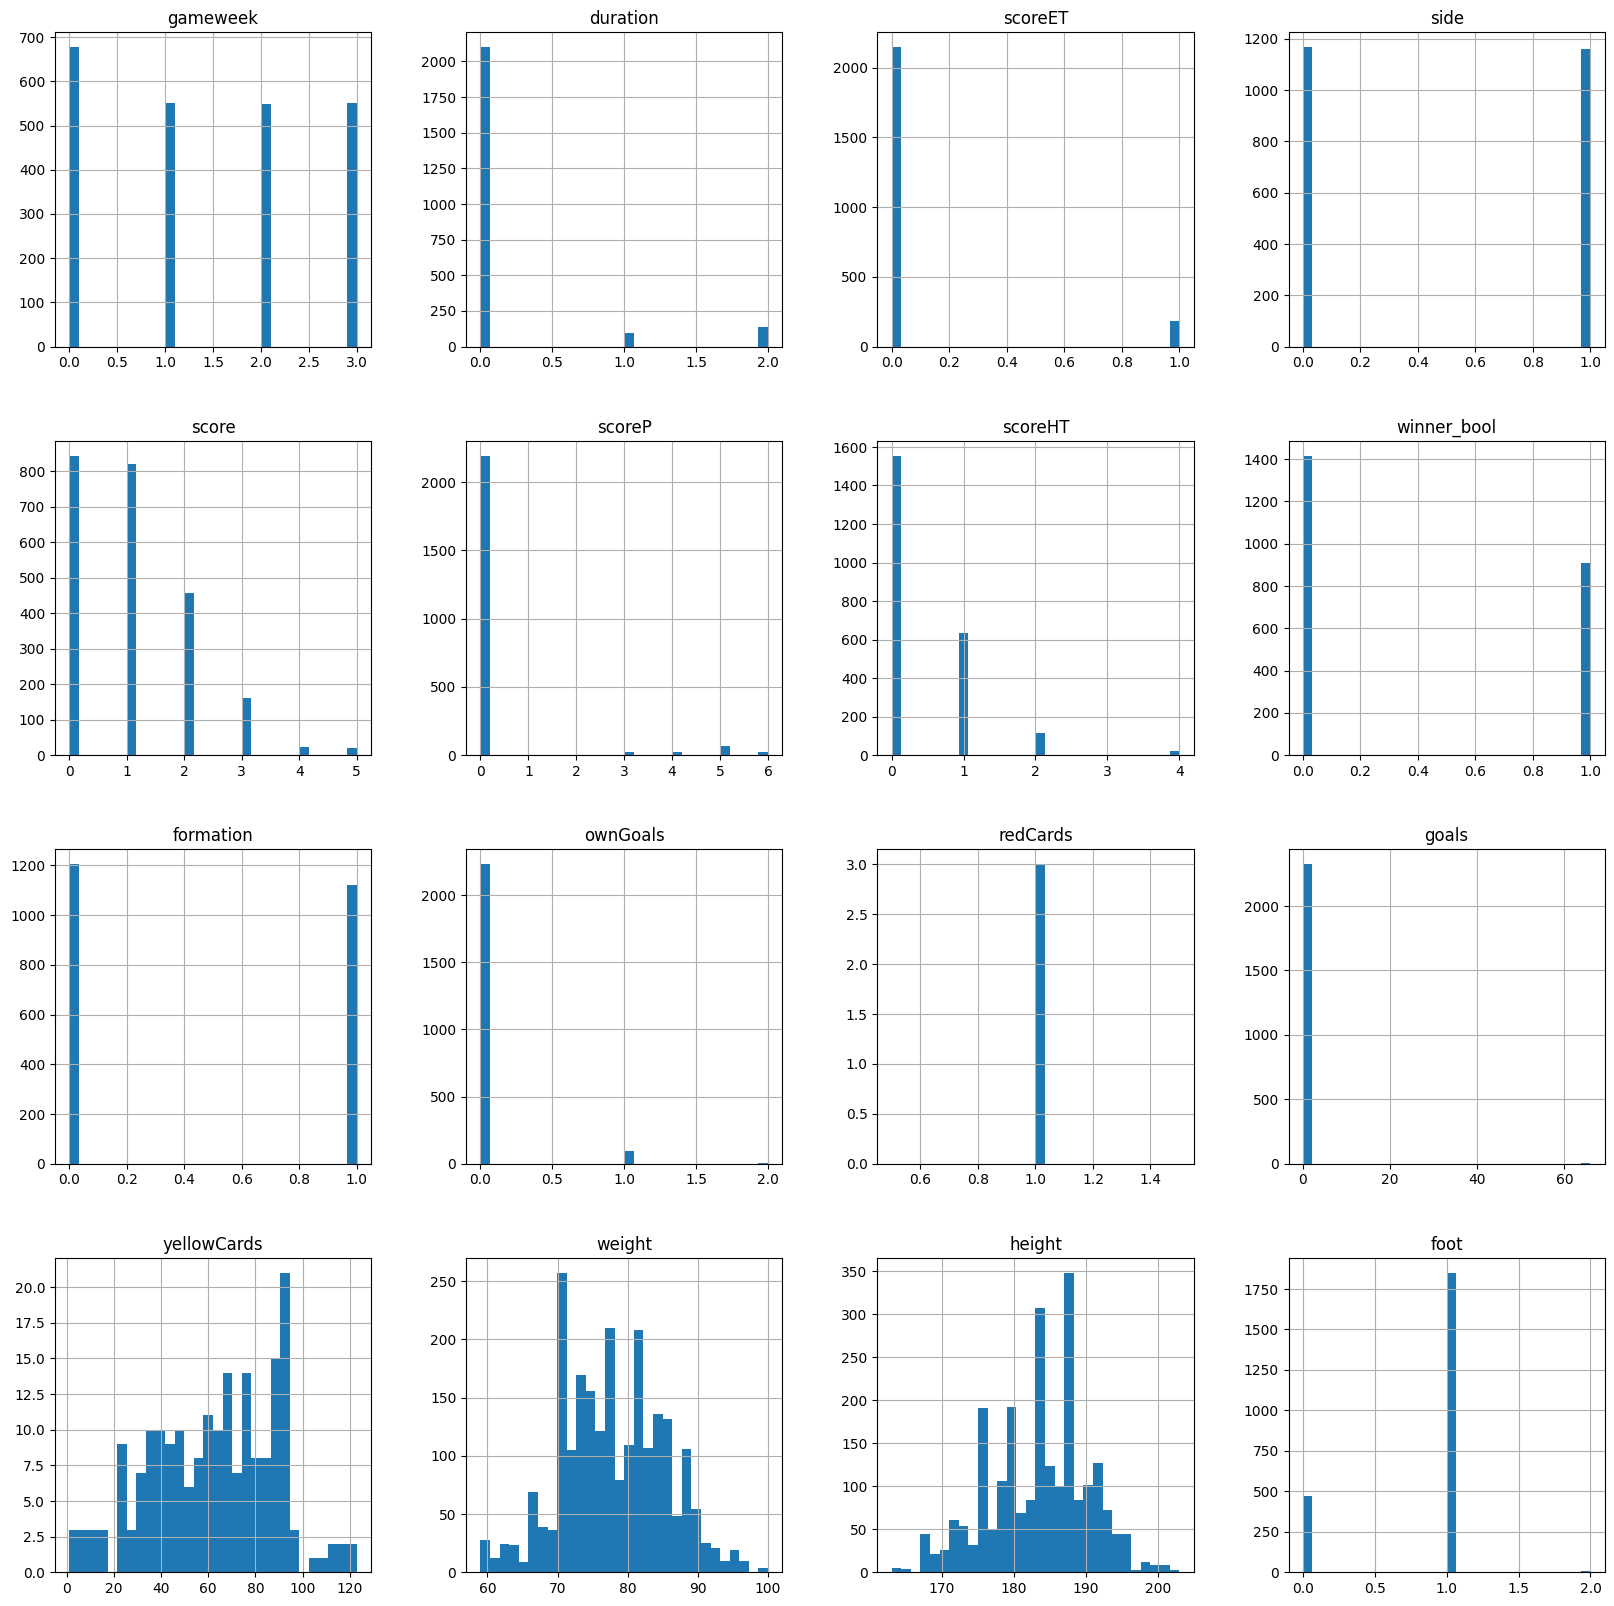

In [36]:
m_t_p_dp_changed.hist(figsize=(20, 20), bins=30)
plt.show()

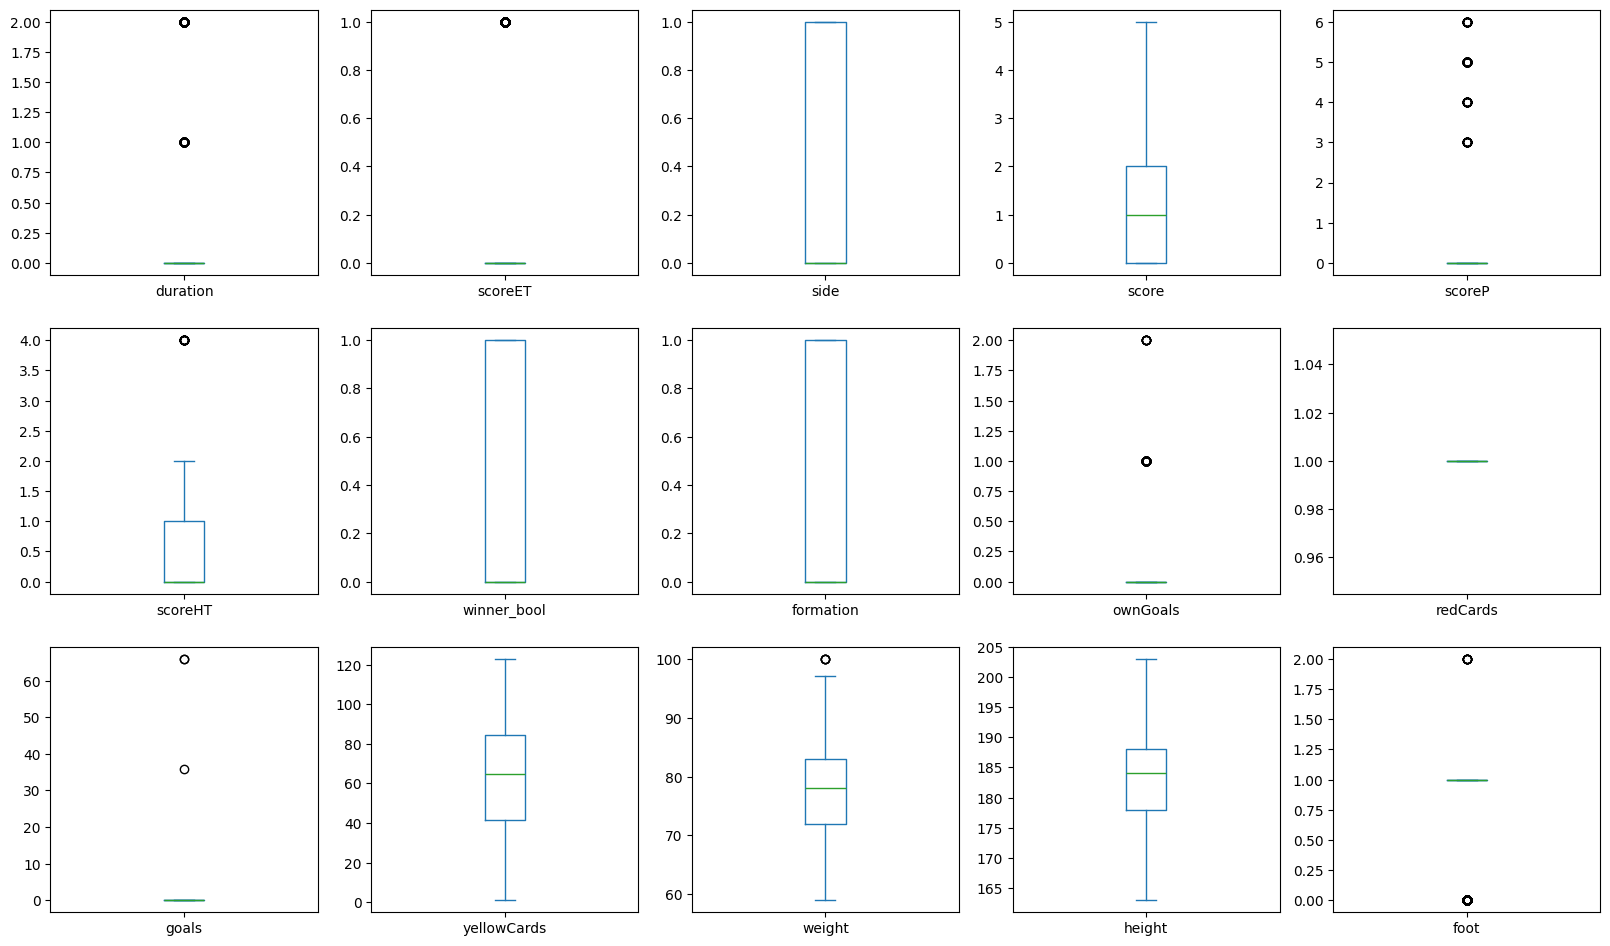

In [37]:
m_t_p_dp_changed.drop('gameweek', axis=1, inplace=True)
m_t_p_dp_changed.plot(kind='box', subplots=True, layout=(5, 5), sharex=False, sharey=False, figsize=(20, 20))
plt.show()

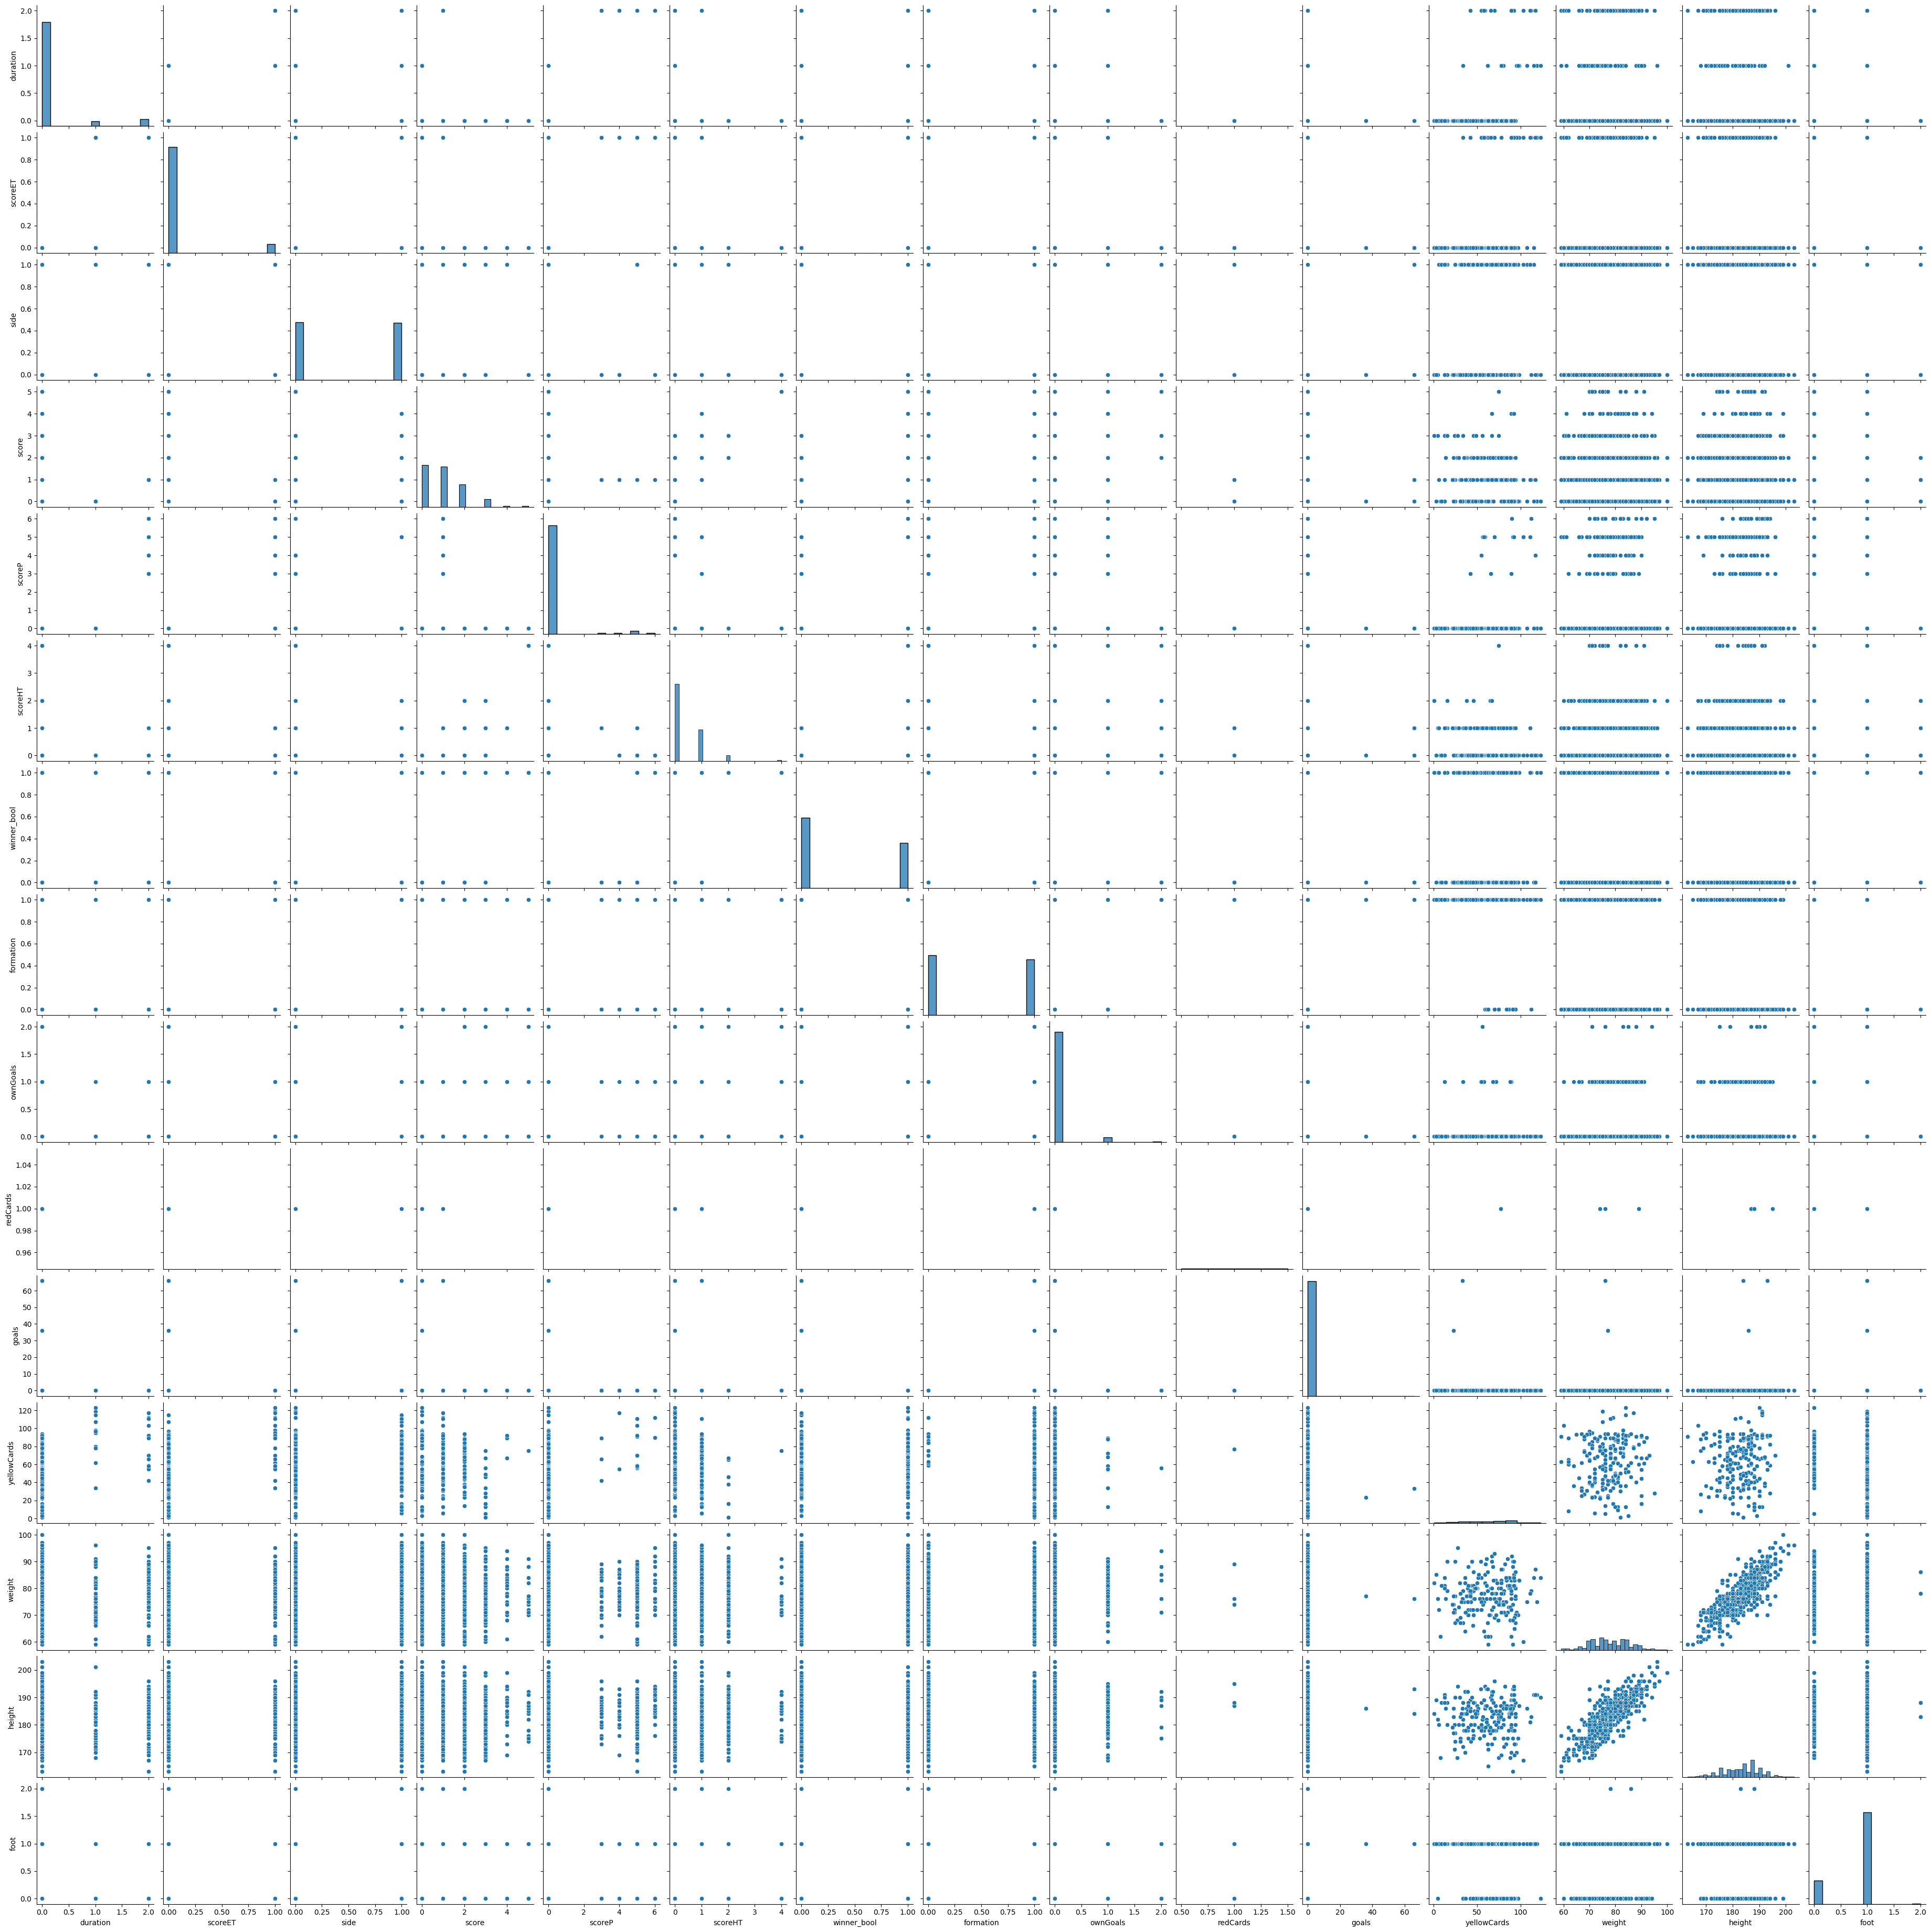

In [38]:
sns.pairplot(m_t_p_dp_changed, height=2.5)
plt.show()

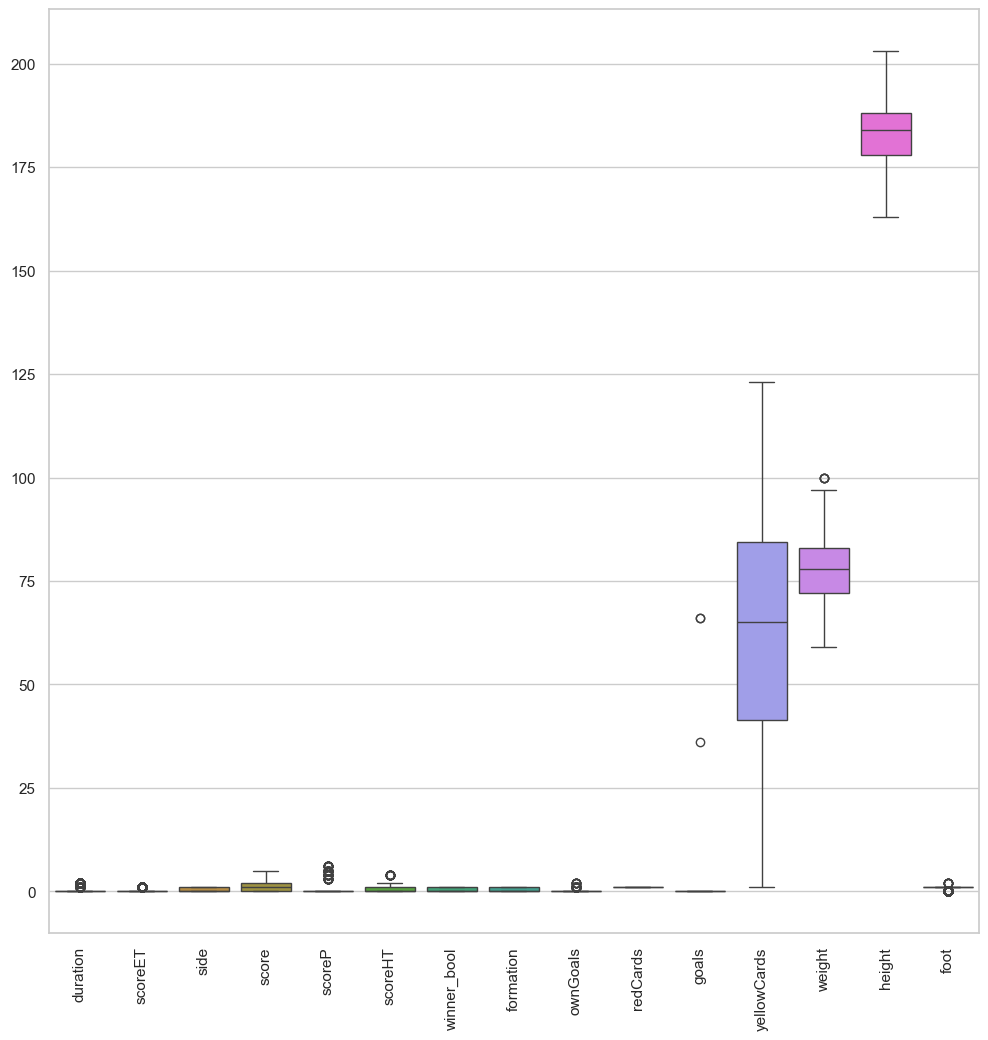

In [39]:
sns.set(style='whitegrid', palette='muted')
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax = sns.boxplot(data=m_t_p_dp_changed)
plt.xticks(rotation=90)
plt.show()

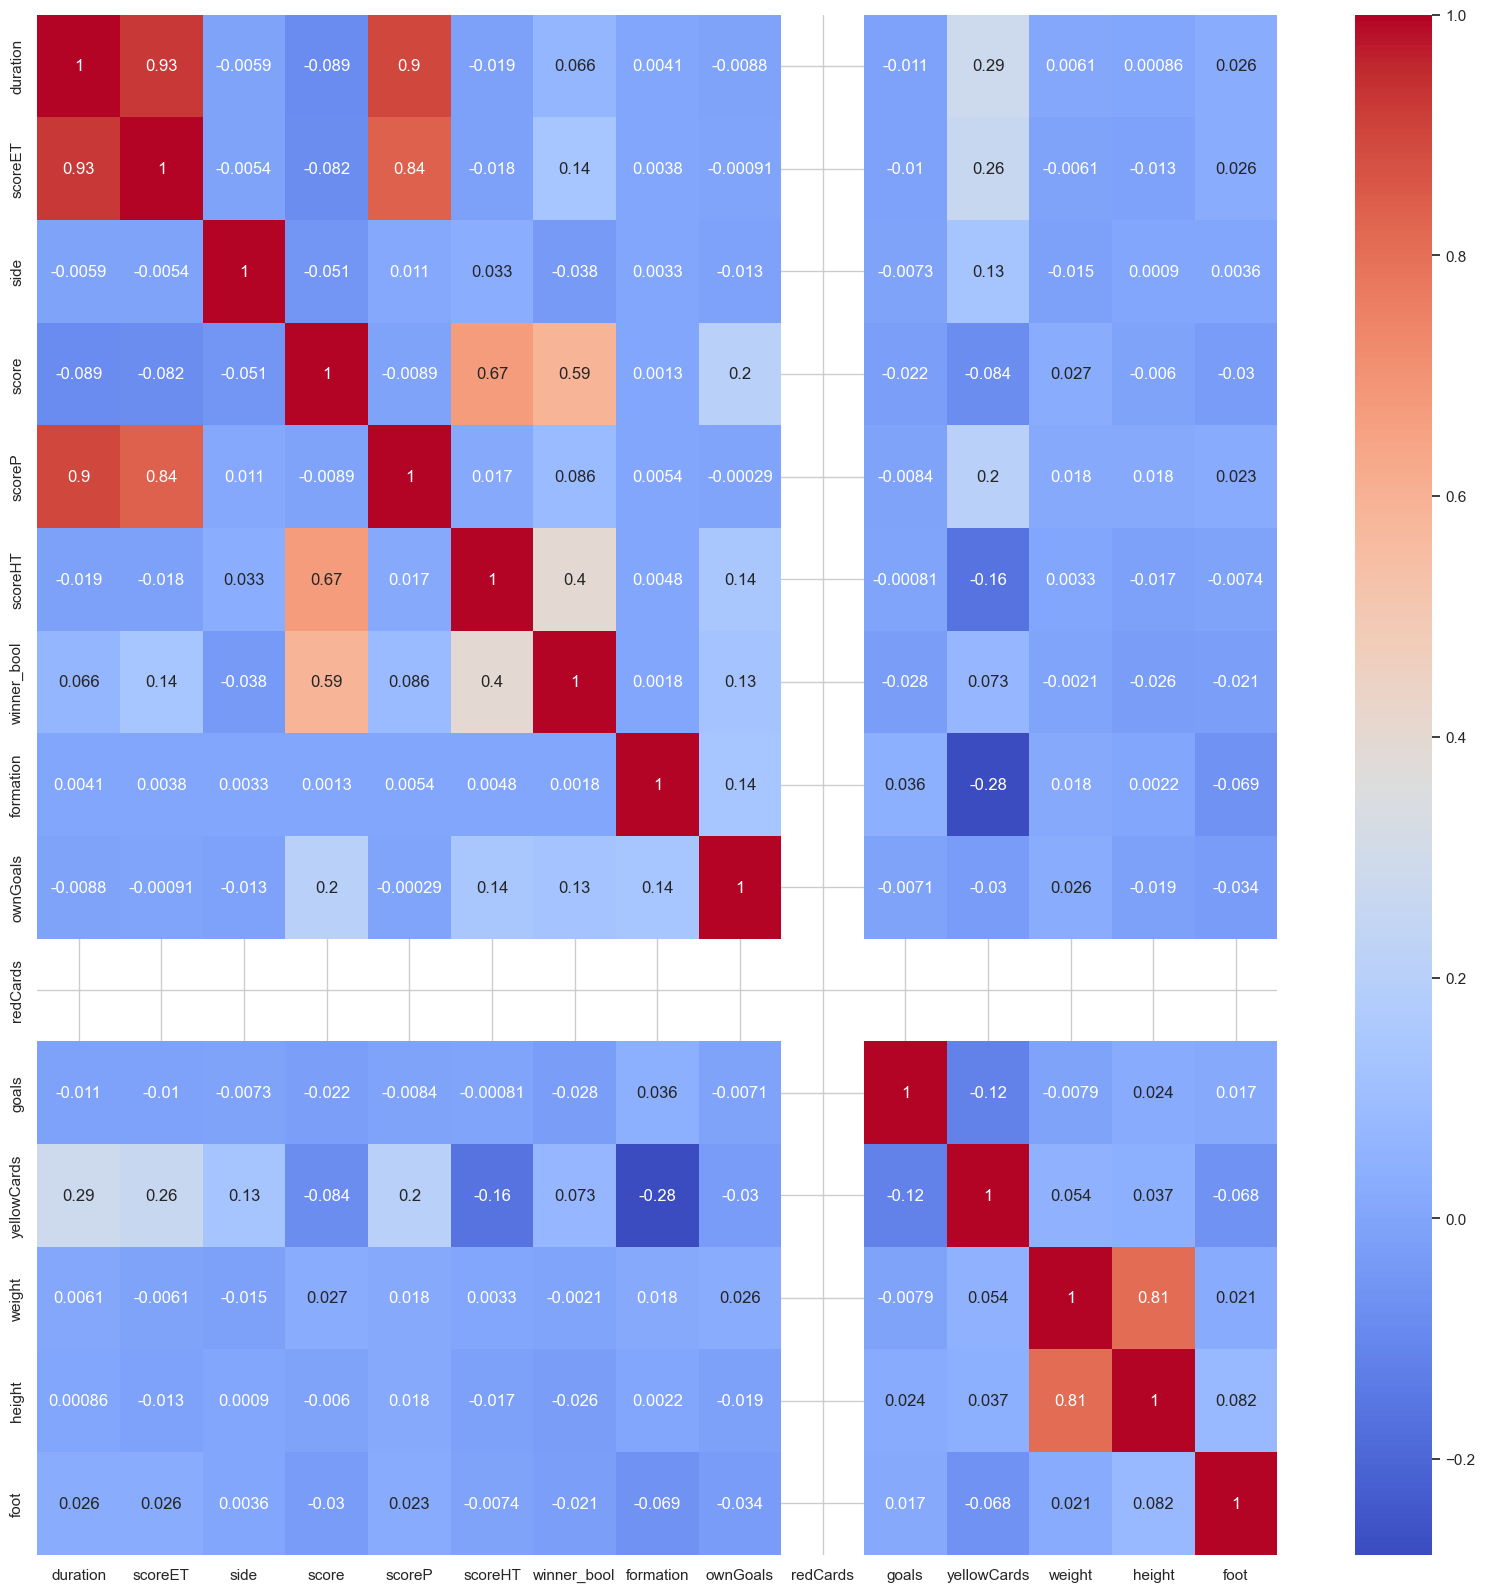

In [40]:
# show the correlation between the columns
corr = m_t_p_dp_changed.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

### Left footers vs Right footers

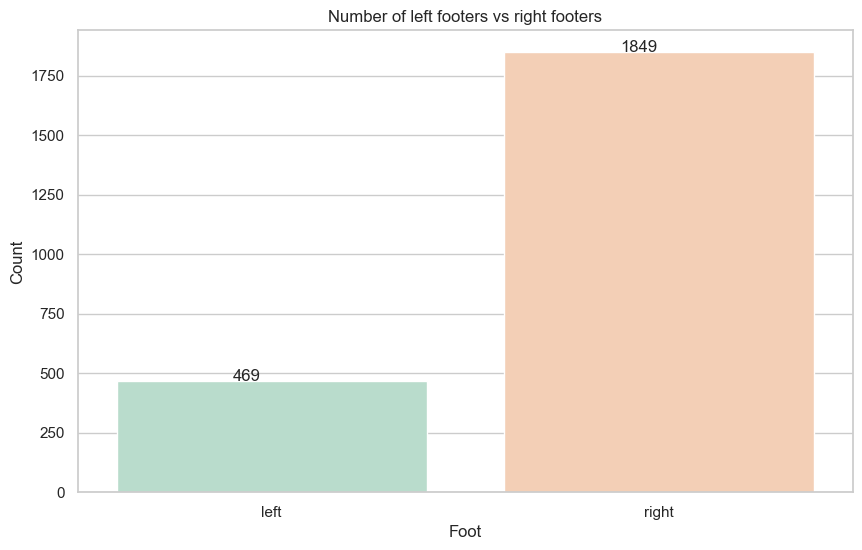

In [41]:
left_footers = len(m_t_p_dp_changed[m_t_p_dp_changed['foot'] == 0])
right_footers = len(m_t_p_dp_changed[m_t_p_dp_changed['foot'] == 1])

foot_df = pd.DataFrame({'foot': ['left', 'right'], 'count': [left_footers, right_footers]})

plt.figure(figsize=(10, 6))
sns.barplot(x='foot', y='count', data=foot_df, palette='Pastel2', hue='foot', legend=False)
for i, v in enumerate([left_footers, right_footers]):
    plt.text(i - 0.1, v + 0.5, str(v))
plt.title('Number of left footers vs right footers')
plt.xlabel('Foot')
plt.ylabel('Count')
plt.show()

### The number of Left footers in winning teams vs loosing teams

         result  count
0  winning team    192
1  lossing team    277


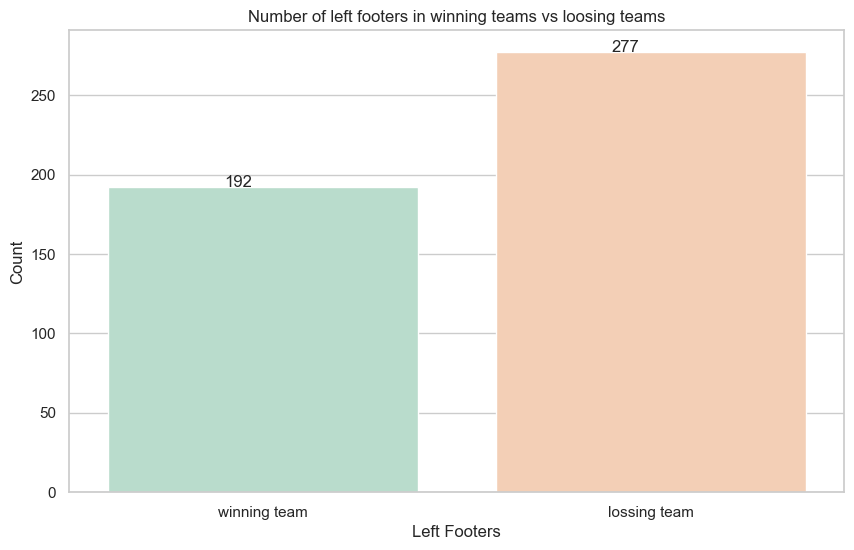

In [42]:
left_footers_win = len(m_t_p_dp_changed[(m_t_p_dp_changed['foot'] == 0) & (m_t_p_dp_changed['winner_bool'] == 1)])
left_footers_lose = len(m_t_p_dp_changed[(m_t_p_dp_changed['foot'] == 0) & (m_t_p_dp_changed['winner_bool'] == 0)])

foot_win_df = pd.DataFrame({'result': ['winning team', 'lossing team'], 'count': [left_footers_win, left_footers_lose]})
print(foot_win_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='result', y='count', data=foot_win_df, palette='Pastel2', hue='result', legend=False)
for i, v in enumerate([left_footers_win, left_footers_lose]):
    plt.text(i - 0.1, v + 0.5, str(v))
plt.title('Number of left footers in winning teams vs loosing teams')
plt.xlabel('Left Footers')
plt.ylabel('Count')
plt.show()

In [43]:
# the difference between the number of left footers in the winning team and the loosing team
#
# (number of left footers in the winning team) - (number of left footers in the loosing team)
#
# 0 means equal number of left footers in both teams
# > 0 means more left footers in the winning team
# < 0 means more left footers in the loosing team

draw_count = df['winner'].value_counts()[0]
more_left_footers_win = 0
more_left_footers_loos = 0
differance = []
uniq_matches  = match_team_ply_dply_df['matchId'].unique()
left_more = {'winners': [], 'loosers': []}

# ------------------

max_height = {'winners': [], 'loosers': []}
min_height = {'winners': [], 'loosers': []}
avg_height = {'winners': [], 'loosers': []}

# ------------------

max_weight = {'winners': [], 'loosers': []}
min_weight = {'winners': [], 'loosers': []}
avg_weight = {'winners': [], 'loosers': []}

# ------------------

all = {
    'winners_max_height': [], 
    'winners_min_height': [], 
    'winners_ave_height': [],
    'winners_max_weight': [],
    'winners_min_weight': [],
    'winners_ave_weight': [],
    'winners_left_more': [], 
    'loosers_max_height': [], 
    'loosers_min_height': [], 
    'loosers_ave_height': [],
    'loosers_max_weight': [],
    'loosers_min_weight': [],
    'loosers_ave_weight': [],
    'loosers_left_more': []
    }

# create a empty dataframe with the columns winners and loosers
left_footers_no_df = pd.DataFrame(columns=['match','team','outcome', 'no_of_left_footers'])
only_wl_lf_no_df = pd.DataFrame(columns=['match','team','outcome', 'no_of_left_footers'])

for match in uniq_matches:
    left_footers_in_winning = 0
    left_footers_in_loosing = 0
    left_footers_in_draw_1 = 0
    left_footers_in_draw_2 = 0
    draw_teamId1 = []
    draw_teamId2 = []
    height_of_winning = []
    height_of_loosing = []
    weight_of_winning = []
    weight_of_loosing = []
    
    for row in match_team_ply_dply_df.index:
        if match_team_ply_dply_df['matchId'][row] == match:
            if int(match_team_ply_dply_df['winner'][row]) == 0:
                if draw_teamId1 == [] and draw_teamId2 == []:
                    draw_teamId1.append(int(match_team_ply_dply_df['teamId'][row]))
                elif draw_teamId1[0] != match_team_ply_dply_df['teamId'][row] and draw_teamId2 == []:
                    draw_teamId2.append(int(match_team_ply_dply_df['teamId'][row]))
                
                if draw_teamId1[0] == match_team_ply_dply_df['teamId'][row]:
                    if match_team_ply_dply_df['foot'][row] == 'left':
                        left_footers_in_draw_1 += 1
                elif draw_teamId2[0] == match_team_ply_dply_df['teamId'][row]:
                    if match_team_ply_dply_df['foot'][row] == 'left':
                        left_footers_in_draw_2 += 1
                
            elif match_team_ply_dply_df['winner_bool'][row] == 1:
                # Left footers in winning team
                if match_team_ply_dply_df['foot'][row] == 'left':
                    left_footers_in_winning += 1
                else:
                    continue # will have to make a pass
                
                # Height of winning team
                height_of_winning.append(match_team_ply_dply_df['height'][row])

                # Weight of winning team
                weight_of_winning.append(match_team_ply_dply_df['weight'][row])

                # All
                all.get('winners_max_height').append(match_team_ply_dply_df['height'][row])
                all.get('winners_min_height').append(match_team_ply_dply_df['height'][row])
                all.get('winners_ave_height').append(match_team_ply_dply_df['height'][row])
                all.get('winners_max_weight').append(match_team_ply_dply_df['weight'][row])
                all.get('winners_min_weight').append(match_team_ply_dply_df['weight'][row])
                all.get('winners_ave_weight').append(match_team_ply_dply_df['weight'][row])
                winning_teamId = match_team_ply_dply_df['teamId'][row]
                
            else:
                # Left footers in loosing team
                if match_team_ply_dply_df['foot'][row] == 'left':
                    left_footers_in_loosing += 1
                else:
                    continue # will have to make a pass

                # Height of loosing team
                height_of_loosing.append(match_team_ply_dply_df['height'][row])

                # Weight of loosing team
                weight_of_loosing.append(match_team_ply_dply_df['weight'][row])

                # All
                all.get('loosers_max_height').append(match_team_ply_dply_df['height'][row])
                all.get('loosers_min_height').append(match_team_ply_dply_df['height'][row])
                all.get('loosers_ave_height').append(match_team_ply_dply_df['height'][row])
                all.get('loosers_max_weight').append(match_team_ply_dply_df['weight'][row])
                all.get('loosers_min_weight').append(match_team_ply_dply_df['weight'][row])
                all.get('loosers_ave_weight').append(match_team_ply_dply_df['weight'][row])
                loosing_teamId = match_team_ply_dply_df['teamId'][row]
        else:
            continue
    # print(f'left_footers_in_winning: {left_footers_in_winning}, left_footers_in_loosing: {left_footers_in_loosing}')

    # insert the number of left footers in the winning and loosing team in the felt_footers_no_df dataframe
    if draw_teamId1 != [] and draw_teamId2 != []:
        left_footers_no_df.loc[len(left_footers_no_df), ['match','team','outcome','no_of_left_footers']] = [match,draw_teamId1[len(draw_teamId1)-1],'Draw1', left_footers_in_draw_1]
        left_footers_no_df.loc[len(left_footers_no_df), ['match','team','outcome','no_of_left_footers']] = [match,draw_teamId2[len(draw_teamId2)-1],'Draw2', left_footers_in_draw_2]
    elif draw_teamId1 == [] and draw_teamId2 == []:
        left_footers_no_df.loc[len(left_footers_no_df), ['match','team','outcome','no_of_left_footers']] = [match,winning_teamId,'winning', left_footers_in_winning]
        left_footers_no_df.loc[len(left_footers_no_df), ['match','team','outcome','no_of_left_footers']] = [match,loosing_teamId,'loosing' , left_footers_in_loosing]
    
        only_wl_lf_no_df.loc[len(only_wl_lf_no_df), ['match','team','outcome','no_of_left_footers']] = [match,winning_teamId,'winning', left_footers_in_winning]
        only_wl_lf_no_df.loc[len(only_wl_lf_no_df), ['match','team','outcome','no_of_left_footers']] = [match,loosing_teamId,'loosing' , left_footers_in_loosing]

    if left_footers_in_winning > left_footers_in_loosing:
        more_left_footers_win += 1
        left_more.get('winners').append(left_footers_in_winning - left_footers_in_loosing)
        left_more.get('loosers').append(0)
        all.get('winners_left_more').append(left_footers_in_winning - left_footers_in_loosing)
    elif left_footers_in_loosing > left_footers_in_winning:
        more_left_footers_loos += 1
        left_more.get('winners').append(0)
        left_more.get('loosers').append(left_footers_in_loosing - left_footers_in_winning)
        all.get('loosers_left_more').append(left_footers_in_loosing - left_footers_in_winning)
    else:
        continue

    differance.append(left_footers_in_winning - left_footers_in_loosing)

    if height_of_winning == []:
        height_of_winning.append(np.nan)
    # Height of winning team
    max_height.get('winners').append(max(height_of_winning))
    min_height.get('winners').append(min(height_of_winning))
    avg_height.get('winners').append(sum(height_of_winning)/len(height_of_winning))
    # Height of loosing team
    max_height.get('loosers').append(max(height_of_loosing))
    min_height.get('loosers').append(min(height_of_loosing))
    avg_height.get('loosers').append(sum(height_of_loosing)/len(height_of_loosing))

    if weight_of_winning == []:
        weight_of_winning.append(np.nan)
    # Weight of winning team
    max_weight.get('winners').append(max(weight_of_winning))
    min_weight.get('winners').append(min(weight_of_winning))
    avg_weight.get('winners').append(sum(weight_of_winning)/len(weight_of_winning))

    # Weight of loosing team
    max_weight.get('loosers').append(max(weight_of_loosing))
    min_weight.get('loosers').append(min(weight_of_loosing))
    avg_weight.get('loosers').append(sum(weight_of_loosing)/len(weight_of_loosing))

print(f"more_left_footers_win: {more_left_footers_win} times")
print(f"more_left_footers_loos: {more_left_footers_loos} times")
print(f"equal number of left footers: {len(uniq_matches) - (more_left_footers_win + more_left_footers_loos + draw_count)} times")
print(f"draw_count: {draw_count}")

addition = len(data) - (len(differance) + draw_count)
differance = [0]*addition + differance

more_left_footers_win: 20 times
more_left_footers_loos: 14 times
equal number of left footers: 6 times
draw_count: 11


In [44]:
only_wl_lf_no_df.head()

,match,team,outcome,no_of_left_footers
0,1694440,9905,winning,4
1,1694440,4418,loosing,8
2,1694439,4418,winning,8
3,1694439,3148,loosing,4
4,1694438,9905,winning,4


<Axes: xlabel='outcome', ylabel='no_of_left_footers'>

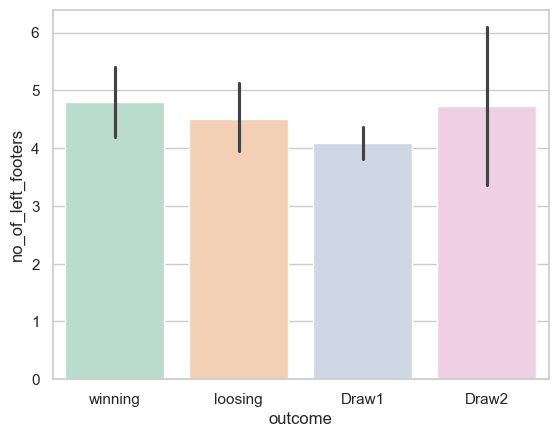

In [45]:
# wont be using this
sns.barplot(x='outcome', y='no_of_left_footers', data=left_footers_no_df, palette='Pastel2', hue='outcome', legend=False, errorbar=("ci",95))


In [46]:
# t test from only_wl_lf_no_df

df = pd.DataFrame(only_wl_lf_no_df)
df['no_of_left_footers'] = pd.to_numeric(df['no_of_left_footers'])
dff = df[df['outcome'].isin(['winning', 'loosing'])]
winning = dff[dff['outcome'] == 'winning']
loosing = dff[dff['outcome'] == 'loosing']

t_statistic, p_value = stats.ttest_ind(winning['no_of_left_footers'], loosing['no_of_left_footers'], equal_var=False, nan_policy='omit')

print(f"t_statistic: {t_statistic}")
print(f"p value: {p_value}")

only_wl_lf_no_df.head(1)

t_statistic: 0.6747243276242062
p value: 0.501847469530339


,match,team,outcome,no_of_left_footers
0,1694440,9905,winning,4


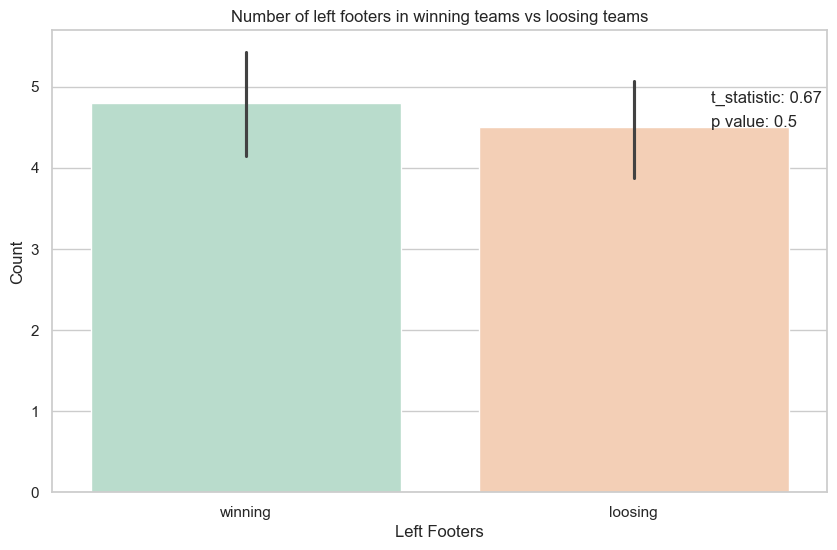

In [47]:
# show the t_statistic and p_value on the graph
plt.figure(figsize=(10, 6))
sns.barplot(x='outcome', y='no_of_left_footers', data=only_wl_lf_no_df, palette='Pastel2', hue='outcome', legend=False, errorbar=("ci",95))
plt.title('Number of left footers in winning teams vs loosing teams')
plt.xlabel('Left Footers')
plt.ylabel('Count')
plt.text(1.2, 4.8, f"t_statistic: {round(t_statistic,2)}")
plt.text(1.2, 4.5, f"p value: {round(p_value,2)}")
plt.show()

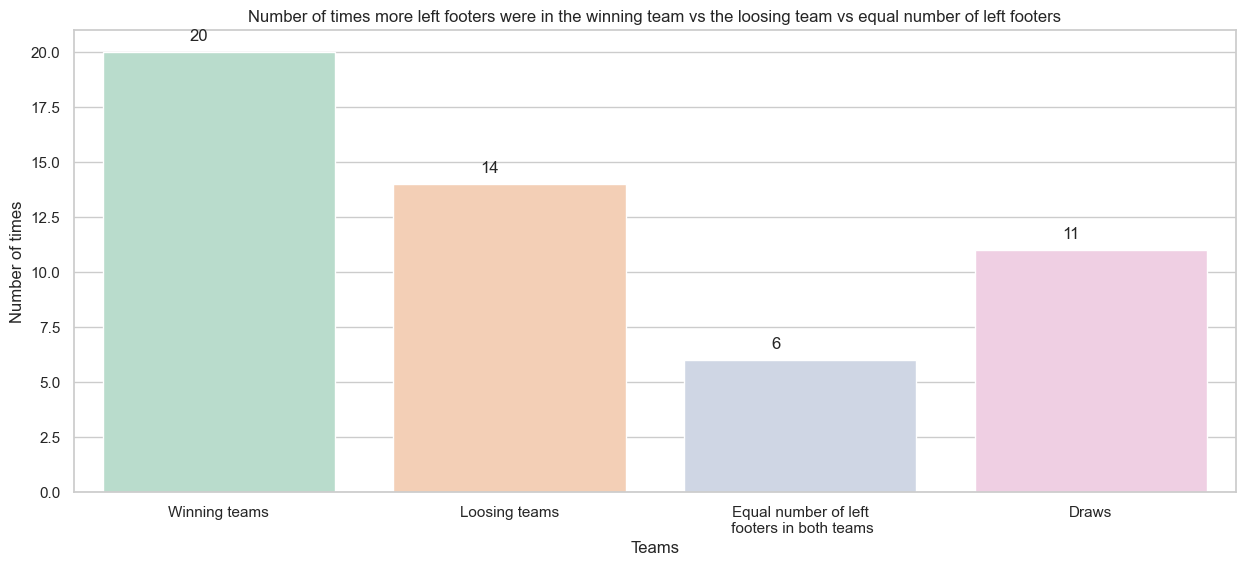

In [48]:
# won't be using this

# since the final is a single number, we can use a bar plot without error bars
plt.figure(figsize=(15, 6))
# wrap the lables on the x axis
sns.barplot(
    x=['Winning teams', 'Loosing teams', 'Equal number of left\n footers in both teams','Draws'], 
    y=[more_left_footers_win, more_left_footers_loos, len(uniq_matches) - (more_left_footers_win + more_left_footers_loos + draw_count ),draw_count], 
    palette='Pastel2', 
    hue=['Winning teams', 'Loosing teams', 'Equal number of left\n footers in both teams','Draws'], 
    legend=False
    )
plt.title('Number of times more left footers were in the winning team vs the loosing team vs equal number of left footers')
# put the number of times on top of each bar

for i, v in enumerate([more_left_footers_win, more_left_footers_loos, len(uniq_matches) - (more_left_footers_win + more_left_footers_loos + draw_count), draw_count]):
    plt.text(i - 0.1, v + 0.5, str(v))

plt.xlabel('Teams')
plt.ylabel('Number of times')
plt.show()

In [49]:
# sort the list
differance.sort()
data_counts = Counter(differance)
dif_avg = sum(differance)/len(differance)

# standaed error
std_err = np.std(differance)/np.sqrt(len(differance))

# 95% confidence interval
ci = 1.96 * std_err

# p value
p_value = stats.ttest_1samp(differance, 0)[1]

print(f"Average: {round(dif_avg,2)}")
print(f"Standard Error: {round(std_err,2)}")
print(f"95% Confidence Interval: {round(ci,2)}")
# print(f"p value: {round(p_value,2)}")

# Extract the data and counts from the frequency table
data_values = list(data_counts.keys())
data_counts = list(data_counts.values())

Average: 0.3
Standard Error: 0.39
95% Confidence Interval: 0.76


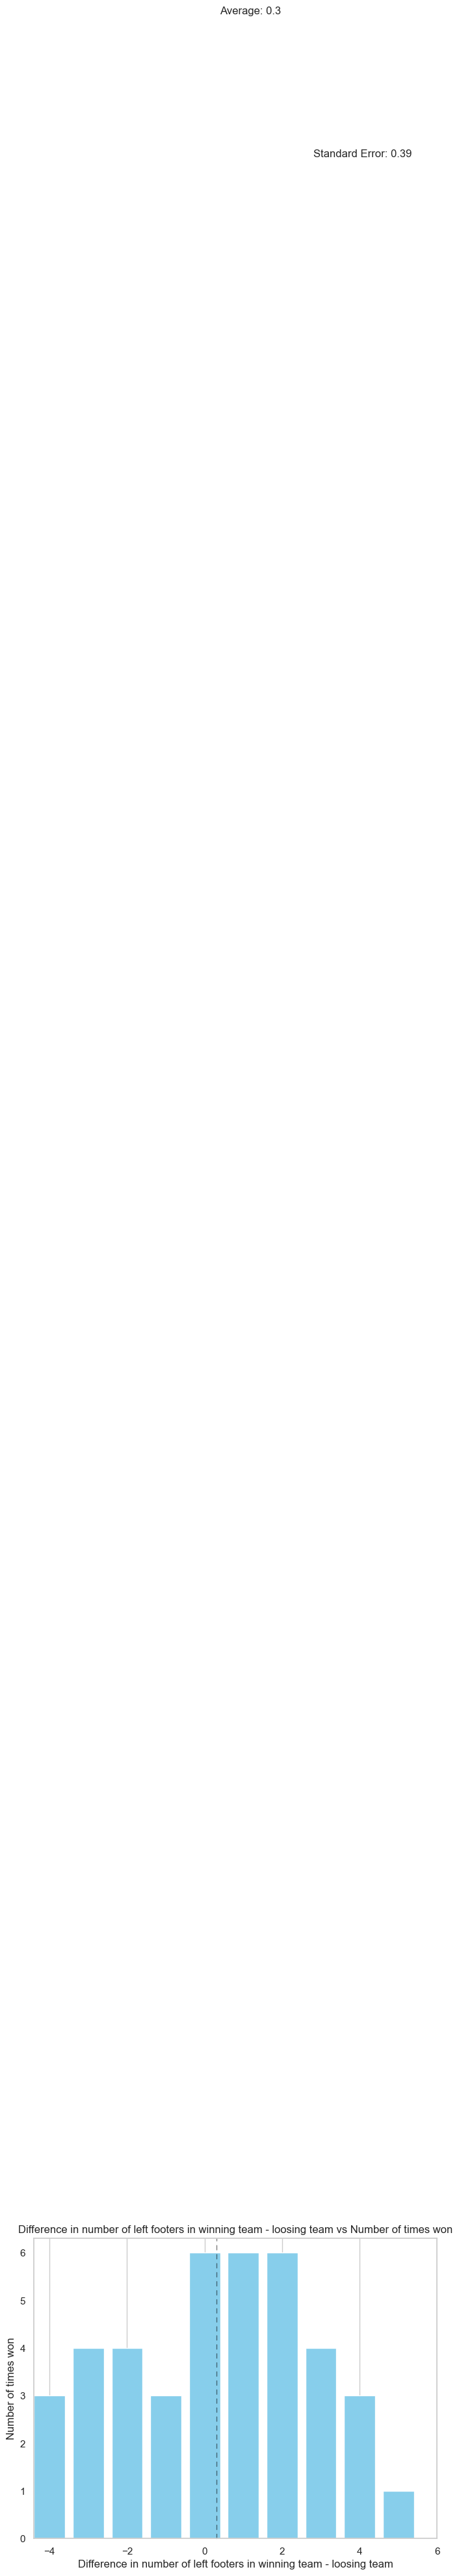

In [50]:
plt.figure(figsize=(8, 6))
plt.bar(data_values, data_counts, color='skyblue')

x = np.array(data_values)
y = np.array(data_counts)

plt.xlabel('Difference in number of left footers in winning team - loosing team')
plt.ylabel('Number of times won')
plt.title('Difference in number of left footers in winning team - loosing team vs Number of times won')
plt.xlim(min(data_values) - abs(min(data_values)) * 0.1, max(data_values) + abs(max(data_values)) * 0.2)
plt.grid(axis='y')
plt.axvline(x=dif_avg, color='black', linewidth=1, linestyle='--', alpha=0.5, label='Average', zorder=1, clip_on=False, dashes=(5, 5), dash_capstyle='round', dash_joinstyle='round')
plt.text(dif_avg + 0.1, 53, f"Average: {round(dif_avg,2)}")
plt.text(2.8, 50, f"Standard Error: {round(std_err,2)}")
# plt.text(4, 47, f"95% Confidence Interval: {round(ci,2)}")
# plt.text(4, 44, f"p value: {round(p_value,2)}")
plt.show()

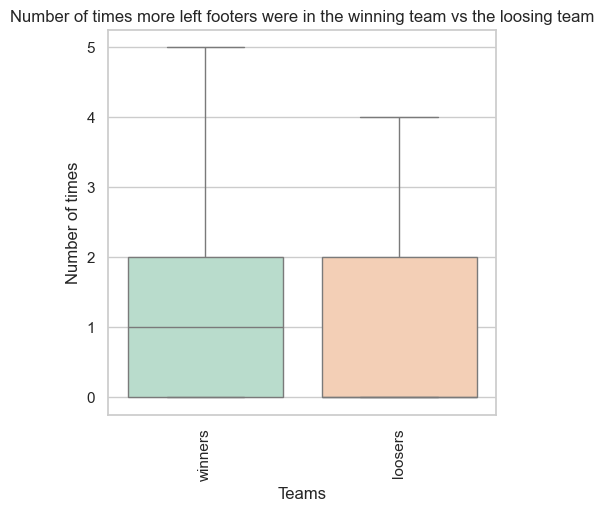

In [51]:
df_win_los = pd.DataFrame(left_more)
df_win_los.head()

plt.figure(figsize=(5, 5))
sns.boxplot(data=df_win_los, palette='Pastel2')
plt.xticks(rotation=90)
plt.title('Number of times more left footers were in the winning team vs the loosing team')
plt.xlabel('Teams')
plt.ylabel('Number of times')
plt.show()

### max height

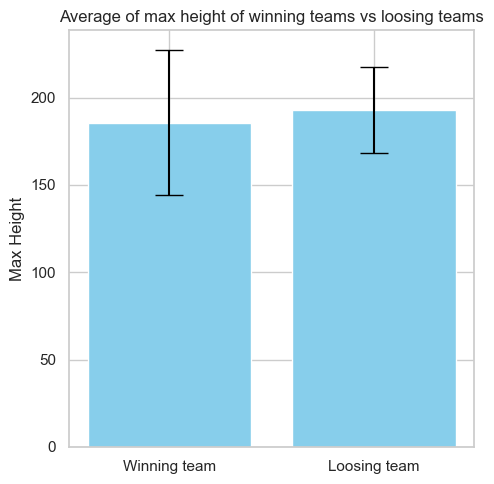

In [52]:
winning_teams = match_team_ply_dply_df.where(match_team_ply_dply_df['winner_bool'] == 1, match_team_ply_dply_df['winner'] != 0, axis=0) 
loosing_teams = match_team_ply_dply_df.where(match_team_ply_dply_df['winner_bool'] == 0, match_team_ply_dply_df['winner'] != 0, axis=0) 

# winning_teams_max_height = winning_teams.groupby(['matchId', 'teamId'])['height'].max().reset_index()
# loosing_teams_max_height = loosing_teams.groupby(['matchId', 'teamId'])['height'].max().reset_index()

# height_df = pd.DataFrame({'team': ['winning team', 'loosing team'], 'max_height': [winning_teams_max_height['height'].mean(), loosing_teams_max_height['height'].mean()]})

# fig, ax = plt.subplots(figsize=(5, 5))
# ax.bar(height_df['team'], height_df['max_height'], yerr=winning_teams_max_height['height'].std() , capsize=10, ecolor='black')
# ax.set_title('Average of max height of winning team vs loosing team')
# ax.set_xlabel('Teams')
# ax.set_ylabel('Average Max Height')
# plt.show()

# Another way to do the same

winning_teams_max_height = np.array(winning_teams.groupby(['matchId', 'teamId'])['height'].max().reset_index())
loosing_teams_max_height = np.array(loosing_teams.groupby(['matchId', 'teamId'])['height'].max().reset_index())

wt_mh_avg = np.mean(winning_teams_max_height[:, 2])
lt_mh_avg = np.mean(loosing_teams_max_height[:, 2])

wt_mh_std = np.std(winning_teams_max_height[:, 2])
lt_mh_std = np.std(loosing_teams_max_height[:, 2])

teams = ['Winning team', 'Loosing team']
x_pos = np.arange(len(teams))
CTEs = [wt_mh_avg, lt_mh_avg]
error = [wt_mh_std, lt_mh_std]

fig, ax = plt.subplots(figsize=(5, 5))
ax.bar(x_pos, CTEs, yerr=error, align='center', ecolor='black', capsize=10, color='skyblue')
ax.set_ylabel('Max Height')
ax.set_xticks(x_pos)
ax.set_xticklabels(teams)
ax.set_title('Average of max height of winning teams vs loosing teams')
ax.yaxis.grid(True)

plt.tight_layout()

plt.show()


In [53]:
max_height_df = pd.DataFrame(max_height)

# calculate the p-value
t_statistic, p_value = stats.ttest_ind(max_height_df['winners'], max_height_df['loosers'], equal_var=False, nan_policy='omit')

print(f"t_statistic: {t_statistic}")
print(f"p value: {p_value}")

max_height_df.head(1)

t_statistic: 0.5978679994621208
p value: 0.5519858117059002


,winners,loosers
0,190.0,192.0


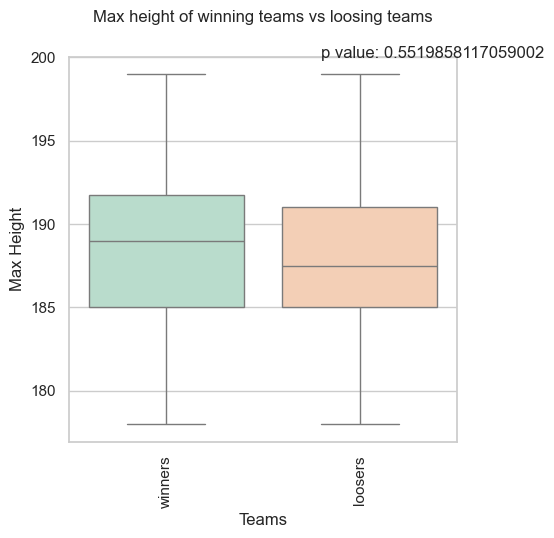

In [54]:
maxV = max(max_height_df['winners'].max(), max_height_df['loosers'].max()) + 1

plt.figure(figsize=(5, 5))
sns.boxplot(data=max_height_df, palette='Pastel2')
plt.xticks(rotation=90)
plt.title('Max height of winning teams vs loosing teams', pad=25)
plt.xlabel('Teams')
plt.ylabel('Max Height')
# plt.text(0.8, 1.9, f"t_statistic: {round(t_statistic,2)}")
plt.text(0.8, maxV, f"p value: {p_value}")
plt.show()

min height

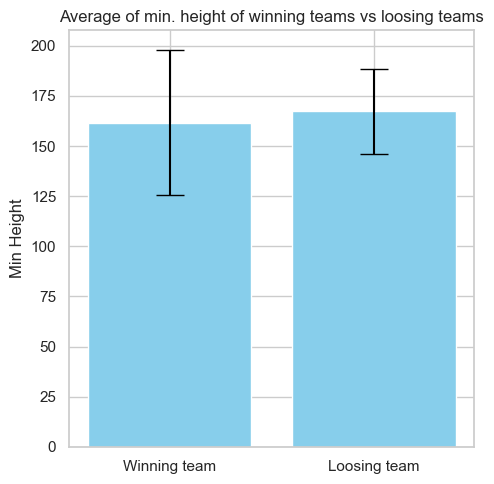

In [55]:
# winning_teams_min_height = winning_teams.groupby(['matchId', 'teamId'])['height'].min().reset_index()
# loosing_teams_min_height = loosing_teams.groupby(['matchId', 'teamId'])['height'].min().reset_index()

# height_df = pd.DataFrame({'team': ['winning team', 'loosing team'], 'min_height': [winning_teams_min_height['height'].mean(), loosing_teams_min_height['height'].mean()]})
# print(height_df)

# fig, ax = plt.subplots(figsize=(5, 5))
# ax.bar(height_df['team'], height_df['min_height'], yerr=winning_teams_min_height['height'].std() , capsize=10, ecolor='black')
# ax.set_title('Average of min height of winning team vs loosing team')
# ax.set_xlabel('Teams')
# ax.set_ylabel('Average Min Height')
# plt.show()

# Another way to do the same


winning_teams_min_height = np.array(winning_teams.groupby(['matchId', 'teamId'])['height'].min().reset_index())
loosing_teams_min_height = np.array(loosing_teams.groupby(['matchId', 'teamId'])['height'].min().reset_index())

wt_minh_avg = np.mean(winning_teams_min_height[:, 2])
lt_minh_avg = np.mean(loosing_teams_min_height[:, 2])

wt_minh_std = np.std(winning_teams_min_height[:, 2])
lt_minh_std = np.std(loosing_teams_min_height[:, 2])

teams = ['Winning team', 'Loosing team']
x_pos = np.arange(len(teams))
CTEs = [wt_minh_avg, lt_minh_avg]
error = [wt_minh_std, lt_minh_std]

fig, ax = plt.subplots(figsize=(5, 5))
ax.bar(x_pos, CTEs, yerr=error, align='center', ecolor='black', capsize=10, color='skyblue')
ax.set_ylabel('Min Height')
ax.set_xticks(x_pos)
ax.set_xticklabels(teams)
ax.set_title('Average of min. height of winning teams vs loosing teams')
ax.yaxis.grid(True)

plt.tight_layout()

plt.show()


In [56]:
min_height_df = pd.DataFrame(min_height)

# calculate the p-value
t_statistic, p_value = stats.ttest_ind(min_height_df['winners'], min_height_df['loosers'], equal_var=False, nan_policy='omit')

print(f"t_statistic: {t_statistic}")
print(f"p value: {p_value}")
min_height_df.head()

t_statistic: 0.14324091994458804
p value: 0.8865599868319998


,winners,loosers
0,170.0,174.0
1,174.0,180.0
2,170.0,168.0
3,174.0,170.0
4,180.0,183.0


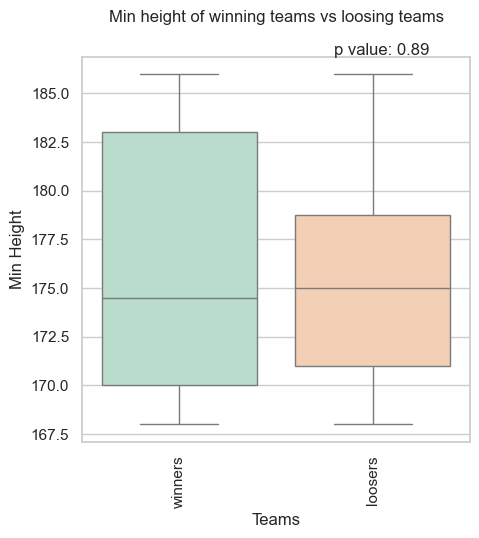

In [57]:
maxV = max(min_height_df['winners'].max(), min_height_df['loosers'].max())+1

plt.figure(figsize=(5, 5))
sns.boxplot(data=min_height_df, palette='Pastel2')
plt.xticks(rotation=90)
plt.title('Min height of winning teams vs loosing teams', pad=25)
# plt.text(0.8, 1.9, f"t_statistic: {round(t_statistic,2)}")
plt.text(0.8, maxV, f"p value: {round(p_value,2)}")
plt.xlabel('Teams')
plt.ylabel('Min Height')
plt.show()

avg height

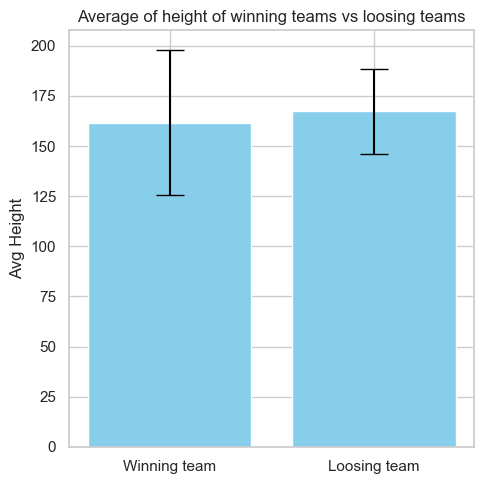

In [58]:
winning_teams_avg_height = np.array(winning_teams.groupby(['matchId', 'teamId'])['height'].min().reset_index())
loosing_teams_avg_height = np.array(loosing_teams.groupby(['matchId', 'teamId'])['height'].min().reset_index())

wt_meanh_avg = np.mean(winning_teams_avg_height[:, 2])
lt_meanh_avg = np.mean(loosing_teams_avg_height[:, 2])

wt_meanh_std = np.std(winning_teams_avg_height[:, 2])
lt_meanh_std = np.std(loosing_teams_avg_height[:, 2])

teams = ['Winning team', 'Loosing team']
x_pos = np.arange(len(teams))
CTEs = [wt_meanh_avg, lt_meanh_avg]
error = [wt_meanh_std, lt_meanh_std]

fig, ax = plt.subplots(figsize=(5, 5))
ax.bar(x_pos, CTEs, yerr=error, align='center', ecolor='black', capsize=10, color='skyblue')
ax.set_ylabel('Avg Height')
ax.set_xticks(x_pos)
ax.set_xticklabels(teams)
ax.set_title('Average of height of winning teams vs loosing teams')
ax.yaxis.grid(True)

plt.tight_layout()

plt.show()

In [59]:
avg_height_df = pd.DataFrame(avg_height)

# calculate the p-value

t_statistic, p_value = stats.ttest_ind(avg_height_df['winners'], avg_height_df['loosers'], equal_var=False, nan_policy='omit')

print(f"t_statistic: {t_statistic}")
print(f"p value: {p_value}")

t_statistic: 0.509910803286746
p value: 0.6118149655334415


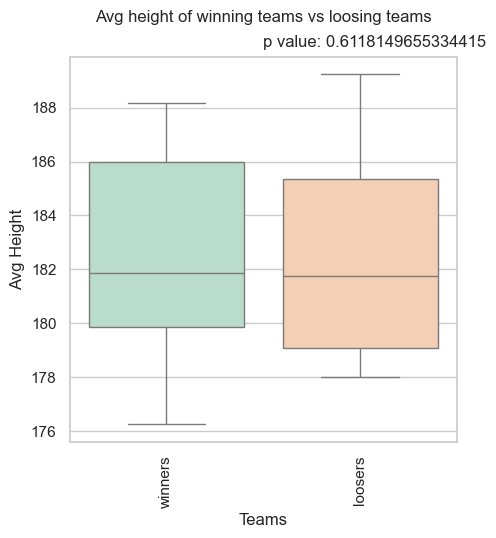

In [60]:
maxV = max(avg_height_df['winners'].max(), avg_height_df['loosers'].max())+1

plt.figure(figsize=(5, 5))
sns.boxplot(data=avg_height_df, palette='Pastel2')
plt.xticks(rotation=90)
plt.title('Avg height of winning teams vs loosing teams', pad=25)
plt.text(0.5, maxV, f"p value: {p_value}")
plt.xlabel('Teams')
plt.ylabel('Avg Height')
plt.show()

max wight

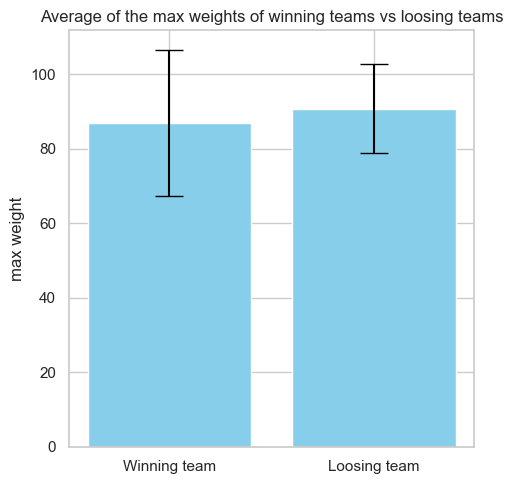

In [61]:
winning_teams_max_weight = np.array(winning_teams.groupby(['matchId', 'teamId'])['weight'].max().reset_index())
loosing_teams_max_weight = np.array(loosing_teams.groupby(['matchId', 'teamId'])['weight'].max().reset_index())

wt_max_weight_avg = np.mean(winning_teams_max_weight[:, 2])
lt_max_weight_avg = np.mean(loosing_teams_max_weight[:, 2])

wt_max_weight_std = np.std(winning_teams_max_weight[:, 2])
lt_max_weight_std = np.std(loosing_teams_max_weight[:, 2])

teams = ['Winning team', 'Loosing team']
x_pos = np.arange(len(teams))
CTEs = [wt_max_weight_avg, lt_max_weight_avg]
error = [wt_max_weight_std, lt_max_weight_std]

fig, ax = plt.subplots(figsize=(5, 5))
ax.bar(x_pos, CTEs, yerr=error, align='center', ecolor='black', capsize=10, color='skyblue')
ax.set_ylabel('max weight')
ax.set_xticks(x_pos)
ax.set_xticklabels(teams)
ax.set_title('Average of the max weights of winning teams vs loosing teams')
ax.yaxis.grid(True)

plt.tight_layout()

plt.show()

In [62]:
max_weight_df = pd.DataFrame(max_weight)

# calculate the p-value

t_statistic, p_value = stats.ttest_ind(max_weight_df['winners'], max_weight_df['loosers'], equal_var=False, nan_policy='omit')

print(f"t_statistic: {t_statistic}")
print(f"p value: {p_value}")

t_statistic: 0.6705529718271716
p value: 0.5050338628465854


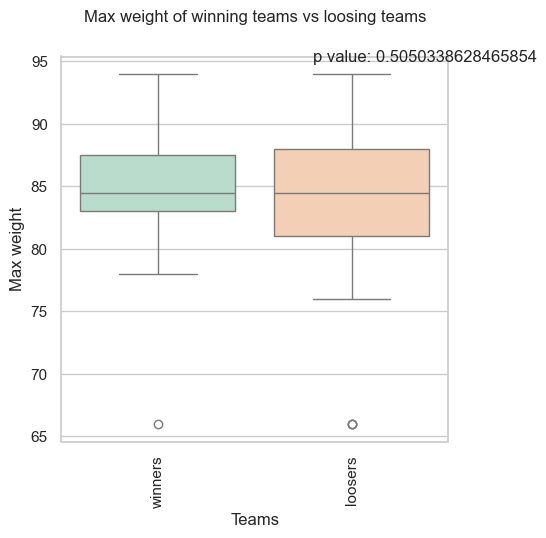

In [63]:
maxV = max(max_weight_df['winners'].max(), max_weight_df['loosers'].max())+1

plt.figure(figsize=(5, 5))
sns.boxplot(data=max_weight_df, palette='Pastel2')
plt.xticks(rotation=90)
plt.title('Max weight of winning teams vs loosing teams', pad=25)
plt.text(0.8, maxV, f"p value: {p_value}")
plt.xlabel('Teams')
plt.ylabel('Max weight')
plt.show()

min weight

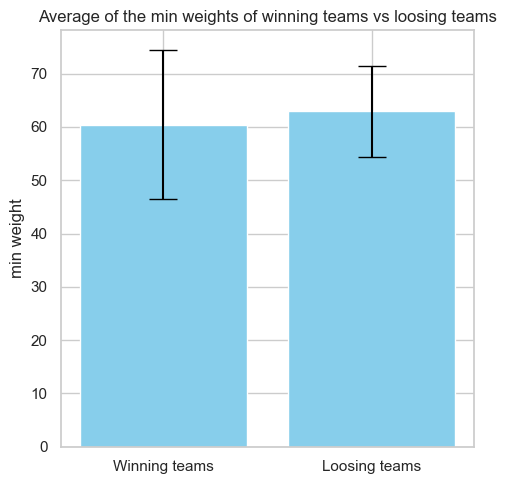

In [64]:
winning_teams_min_weight = np.array(winning_teams.groupby(['matchId', 'teamId'])['weight'].min().reset_index())
loosing_teams_min_weight = np.array(loosing_teams.groupby(['matchId', 'teamId'])['weight'].min().reset_index())

wt_min_weight_avg = np.mean(winning_teams_min_weight[:, 2])
lt_min_weight_avg = np.mean(loosing_teams_min_weight[:, 2])

wt_min_weight_std = np.std(winning_teams_min_weight[:, 2])
lt_min_weight_std = np.std(loosing_teams_min_weight[:, 2])

teams = ['Winning teams', 'Loosing teams']
x_pos = np.arange(len(teams))
CTEs = [wt_min_weight_avg, lt_min_weight_avg]
error = [wt_min_weight_std, lt_min_weight_std]

fig, ax = plt.subplots(figsize=(5, 5))
ax.bar(x_pos, CTEs, yerr=error, align='center', ecolor='black', capsize=10, color='skyblue')
ax.set_ylabel('min weight')
ax.set_xticks(x_pos)
ax.set_xticklabels(teams)
ax.set_title('Average of the min weights of winning teams vs loosing teams')
ax.yaxis.grid(True)

plt.tight_layout()

plt.show()

In [65]:
min_weight_df = pd.DataFrame(min_weight)

# calculate the p-value

t_statistic, p_value = stats.ttest_ind(min_weight_df['winners'], min_weight_df['loosers'], equal_var=False, nan_policy='omit')

print(f"t_statistic: {t_statistic}")
print(f"p value: {p_value}")

t_statistic: 2.247808187502111
p value: 0.028004774687780887


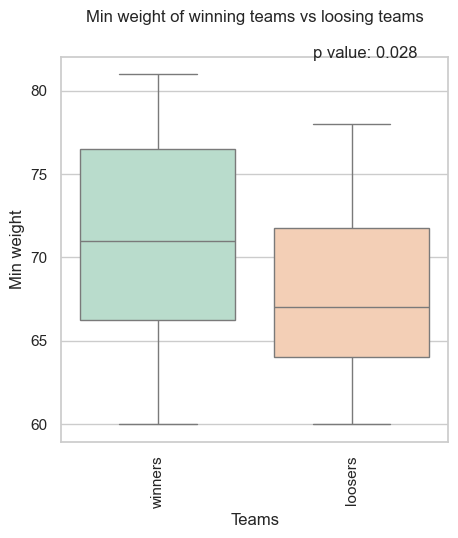

In [66]:
maxV = max(min_weight_df['winners'].max(), min_weight_df['loosers'].max())+1

plt.figure(figsize=(5, 5))
sns.boxplot(data=min_weight_df, palette='Pastel2')
plt.xticks(rotation=90)
plt.title('Min weight of winning teams vs loosing teams', pad=25)
plt.text(0.8, maxV, f"p value: {round(p_value,3)}")
plt.xlabel('Teams')
plt.ylabel('Min weight')
plt.show()

avg weight

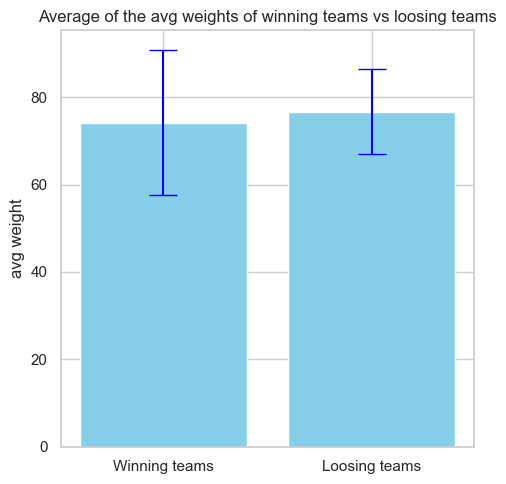

In [67]:
# winning_teams_avg_weight = winning_teams.groupby(['matchId', 'teamId'])['weight'].mean().reset_index()
# loosing_teams_avg_weight = loosing_teams.groupby(['matchId', 'teamId'])['weight'].mean().reset_index()

# weight_df = pd.DataFrame({'team': ['winning team', 'loosing team'], 'avg_weight': [winning_teams_avg_weight['weight'].mean(), loosing_teams_avg_weight['weight'].mean()]})
# print(weight_df)

# plt.figure(figsize=(10, 6))
# sns.barplot(x='team', y='avg_weight', data=weight_df)
# plt.title('Average of avg weight of winning team vs loosing team')
# plt.xlabel('Teams')
# plt.ylabel('Average Weight')
# plt.show()

winning_teams_avg_weight = np.array(winning_teams.groupby(['matchId', 'teamId'])['weight'].mean().reset_index())
loosing_teams_avg_weight = np.array(loosing_teams.groupby(['matchId', 'teamId'])['weight'].mean().reset_index())

wt_avg_weight_avg = np.mean(winning_teams_avg_weight[:, 2])
lt_avg_weight_avg = np.mean(loosing_teams_avg_weight[:, 2])

wt_avg_weight_std = np.std(winning_teams_avg_weight[:, 2])
lt_avg_weight_std = np.std(loosing_teams_avg_weight[:, 2])

teams = ['Winning teams', 'Loosing teams']
x_pos = np.arange(len(teams))
CTEs = [wt_avg_weight_avg, lt_avg_weight_avg]
error = [wt_avg_weight_std, lt_avg_weight_std]

fig, ax = plt.subplots(figsize=(5, 5))
ax.bar(x_pos, CTEs, yerr=error, align='center', ecolor='blue', capsize=10, color='skyblue')
ax.set_ylabel('avg weight')
ax.set_xticks(x_pos)
ax.set_xticklabels(teams)
ax.set_title('Average of the avg weights of winning teams vs loosing teams')
ax.yaxis.grid(True)

plt.tight_layout()

plt.show()

In [68]:
avg_weight_df = pd.DataFrame(avg_weight)

# calculate the p-value

t_statistic, p_value = stats.ttest_ind(avg_weight_df['winners'], avg_weight_df['loosers'], equal_var=False, nan_policy='omit')

print(f"t_statistic: {t_statistic}")
print(f"p value: {p_value}")

t_statistic: 1.7008067039660675
p value: 0.0937702847397254


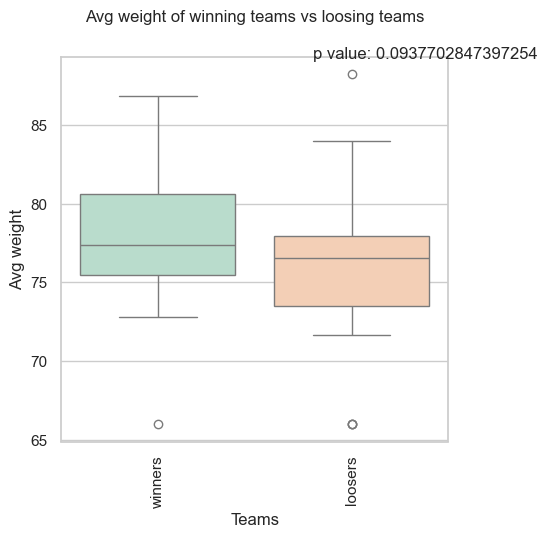

In [69]:
maxV = max(avg_weight_df['winners'].max(), avg_weight_df['loosers'].max())+1

plt.figure(figsize=(5, 5))
sns.boxplot(data=avg_weight_df, palette='Pastel2')
plt.xticks(rotation=90)
plt.title('Avg weight of winning teams vs loosing teams', pad=25)
plt.text(0.8, maxV, f"p value: {p_value}")
plt.xlabel('Teams')
plt.ylabel('Avg weight')
plt.show()

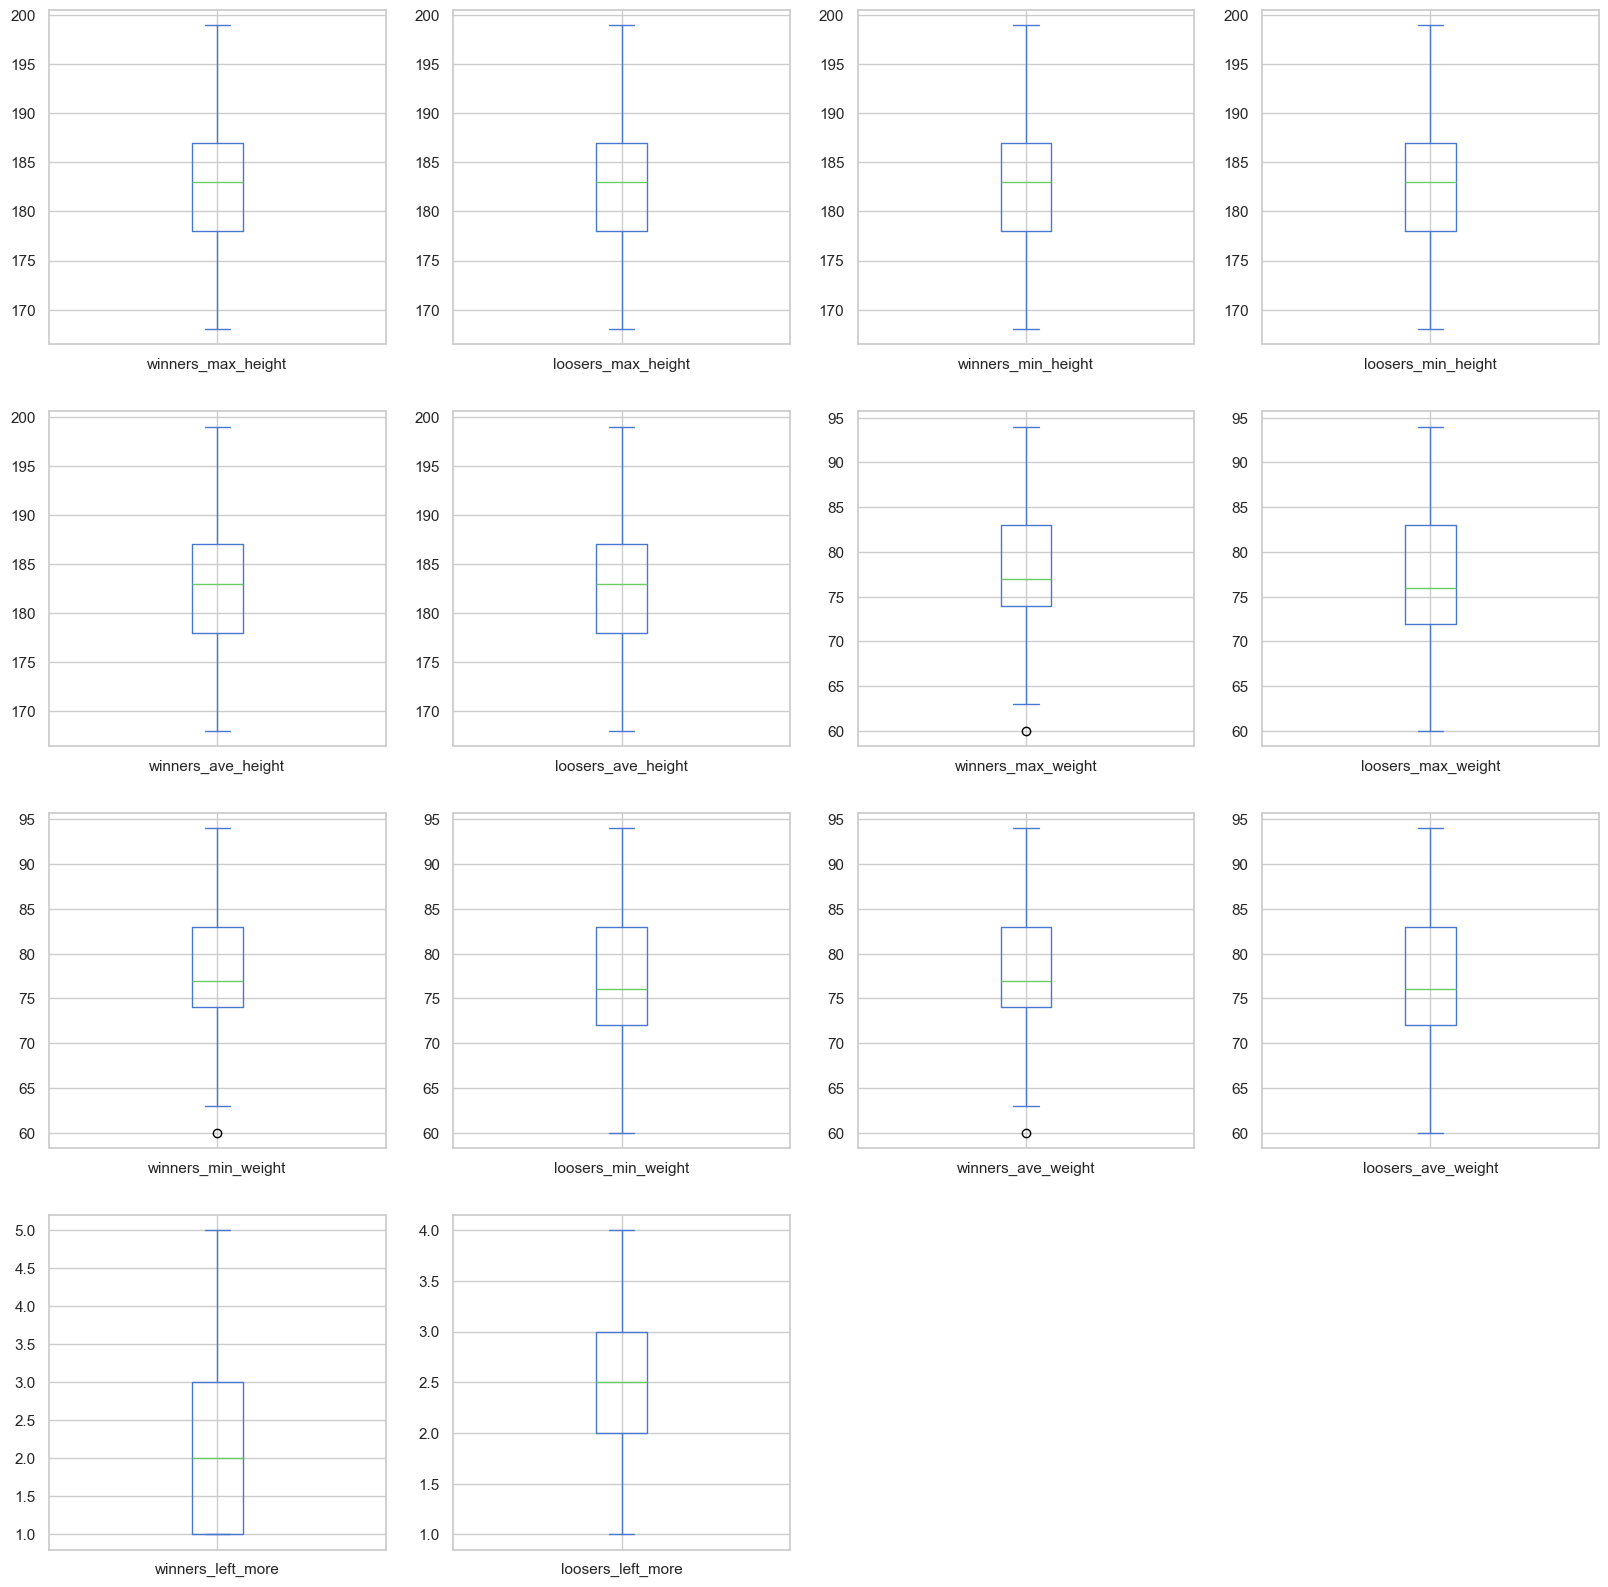

In [70]:
if len(all['winners_max_height']) < len(all['loosers_max_height']):
    all['winners_max_height'].extend([np.nan] * (len(all['loosers_max_height']) - len(all['winners_max_height'])))
    all['winners_min_height'].extend([np.nan] * (len(all['loosers_min_height']) - len(all['winners_min_height'])))
    all['winners_ave_height'].extend([np.nan] * (len(all['loosers_ave_height']) - len(all['winners_ave_height'])))
    all['winners_max_weight'].extend([np.nan] * (len(all['loosers_max_weight']) - len(all['winners_max_weight'])))
    all['winners_min_weight'].extend([np.nan] * (len(all['loosers_min_weight']) - len(all['winners_min_weight'])))
    all['winners_ave_weight'].extend([np.nan] * (len(all['loosers_ave_weight']) - len(all['winners_ave_weight'])))
    all['winners_left_more'].extend([np.nan] * (len(all['loosers_ave_height']) - len(all['winners_left_more'])))
    all['loosers_left_more'].extend([np.nan] * (len(all['loosers_ave_height']) - len(all['loosers_left_more'])))
elif len(all['winners_max_height']) > len(all['loosers_max_height']):
    all['loosers_max_height'].extend([np.nan] * (len(all['winners_max_height']) - len(all['loosers_max_height'])))
    all['loosers_min_height'].extend([np.nan] * (len(all['winners_min_height']) - len(all['loosers_min_height'])))
    all['loosers_ave_height'].extend([np.nan] * (len(all['winners_ave_height']) - len(all['loosers_ave_height'])))
    all['loosers_max_weight'].extend([np.nan] * (len(all['winners_max_weight']) - len(all['loosers_max_weight'])))
    all['loosers_min_weight'].extend([np.nan] * (len(all['winners_min_weight']) - len(all['loosers_min_weight'])))
    all['loosers_ave_weight'].extend([np.nan] * (len(all['winners_ave_weight']) - len(all['loosers_ave_weight'])))
    all['loosers_left_more'].extend([np.nan] * (len(all['winners_ave_height']) - len(all['loosers_left_more'])))
    all['winners_left_more'].extend([np.nan] * (len(all['winners_ave_height']) - len(all['winners_left_more'])))

# print(len(all['loosers_max_height']))
# print(len(all['winners_max_height']))
# print(len(all['loosers_left_more']))
# print(len(all['winners_left_more']))

all_df = pd.DataFrame(all)
all_df = all_df[
    [
        'winners_max_height', 
        'loosers_max_height', 
        'winners_min_height', 
        'loosers_min_height', 
        'winners_ave_height', 
        'loosers_ave_height',
        'winners_max_weight', 
        'loosers_max_weight', 
        'winners_min_weight',
        'loosers_min_weight',
        'winners_ave_weight',
        'loosers_ave_weight',
        'winners_left_more', 
        'loosers_left_more'
        ]
        ]
all_df.plot(kind='box', subplots=True, layout=(4, 4), sharex=False, sharey=False, figsize=(20,20))
plt.show()

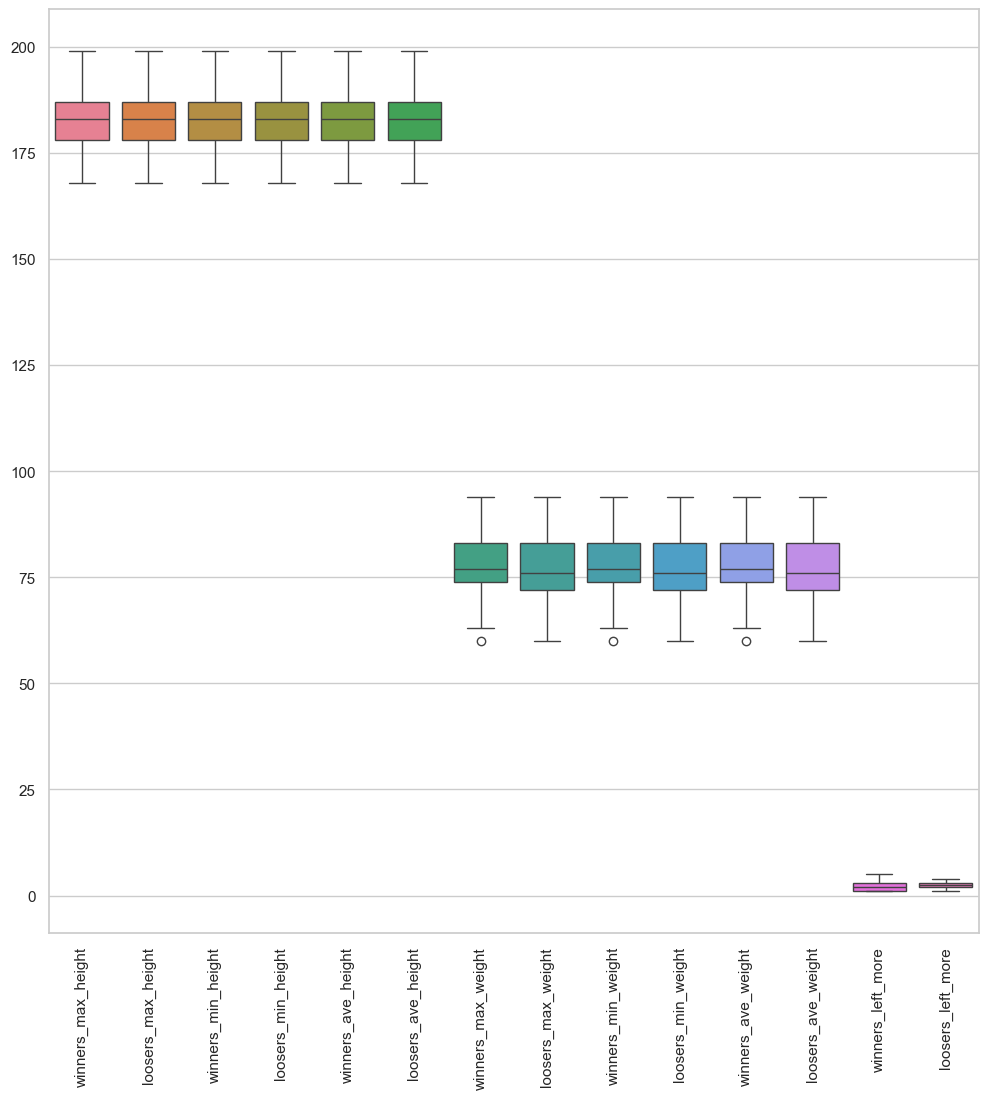

In [71]:
sns.set(style='whitegrid', palette='Pastel2')
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax = sns.boxplot(data=all_df)
plt.xticks(rotation=90)
plt.show()

In [72]:
# Users/dilancroos/LPI/
# !junix -f main_others.ipynb -o export_images/matches_England -p my_prefix